In [1]:
'''使用 ssha,sswa,sssa,ssta + 衍生变量 反演 次表层盐度异常'''

'使用 ssha,sswa,sssa,ssta + 衍生变量 反演 次表层盐度异常'

In [2]:
#导包
from netCDF4 import Dataset
from tensorflow.keras import layers, models
from tensorflow.keras.layers import ConvLSTM2D,LSTM, BatchNormalization, LayerNormalization,Input, Conv3D, TimeDistributed, Flatten
from tensorflow.keras.layers import Concatenate,Conv2D,TimeDistributed, MaxPooling2D, Input, MaxPooling3D
from tensorflow.keras.layers import  Reshape,multiply
from tensorflow.keras.layers import Layer,Lambda,Dot,ReLU, Dense, Dropout, Activation, Flatten,Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import r2_score,accuracy_score,precision_score
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
import tensorflow as tf
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models, layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential, regularizers
# calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd 
import tensorflow as tf
import gc 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import match
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
import cartopy.crs as ccrs
import cartopy.feature
#from mpl_toolkits.basemap import Basemap
%matplotlib inline


In [3]:
# 检查可用GPU数量
len(tf.config.experimental.list_physical_devices('GPU'))

1

# 读取数据

## SSH

In [4]:
extend_num =19   #输入图像大小是11，则extend_num设置为5

In [5]:
data_ssh1 = nc.Dataset(r'D:/data/SSH/SSH_2011-2015_month.nc')
data_ssh2 = nc.Dataset(r'D:/data/SSH/SSH_2016-2021_month.nc')

In [6]:
time_ssh1 = data_ssh1['time'][:]
print('第一段时间长度为：',len(time_ssh1))
time_ssh2 = data_ssh2['time'][:]
print('第二段时间长度为：',len(time_ssh2))

第一段时间长度为： 60
第二段时间长度为： 72


In [7]:
# 查看研究区域经纬度（120°E - 90°W , 0 - 60°N）
ssh_lat = data_ssh1['lat'][:].data
#print(ssh_lat[360:600])                   # 0.125 --- 59.875
ssh_lon = data_ssh1['lon'][:].data
# print(ssh_lon[720+480:])                 # 120.125 ---  179.875    240
# print(ssh_lon[:360])                     #-179.875 ---  -90.125    360

In [8]:

ssh1 = np.concatenate((data_ssh1['ssh'][:,360-extend_num:600+extend_num,1200-extend_num:].data,data_ssh1['ssh'][:,360-extend_num:600+extend_num,:360+extend_num].data),axis=2)
ssh2 = np.concatenate((data_ssh2['ssh'][:,360-extend_num:600+extend_num,1200-extend_num:].data,data_ssh2['ssh'][:,360-extend_num:600+extend_num,:360+extend_num].data),axis=2)
#合并时间
ssh =  np.concatenate((ssh1,ssh2),axis=0)

In [9]:
print('形状:',ssh.shape)
print('最大值与最小值：',np.nanmax(ssh),np.nanmin(ssh))
print('nan的个数：',np.sum(np.isnan(ssh[5:6,:,:]))) #31583

形状: (132, 278, 638)
最大值与最小值： 2.266329 -0.37727273
nan的个数： 43861


### SSHA

In [10]:
ssh.shape

(132, 278, 638)

In [11]:
# 计算SSH 气候学
cli_ssh = ssh  
#cli_ssh = ssh.reshape(11, 12, 250, 610)    
cli_ssh = np.nanmean(cli_ssh,axis = 0)
print('海表面高度平均值',cli_ssh.shape)

海表面高度平均值 (278, 638)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6596\1151614251.py:4: RuntimeWarning: Mean of empty slice
  cli_ssh = np.nanmean(cli_ssh,axis = 0)


In [12]:
ssh.shape

(132, 278, 638)

In [13]:
#exp_cli_ssh = np.tile(cli_ssh, (11, 1, 1))
ssha = ssh - cli_ssh 
print(ssha.shape)

(132, 278, 638)


## SSS

In [14]:
data_sss = nc.Dataset(r'D:/data/SSS/2011-2021_SSS_correct.nc')

In [15]:
# 确定时间
time_sss = data_sss['time'][:]
print(len(time_sss))

132


In [16]:
# 获取研究位置经纬度
sss_lat = data_sss['lat'][:].data
#print(sss_lat[360:600])                  # 0.125 ---- 59.875
sss_lon = data_sss['lon'][:].data
#print(sss_lon[480:480+600])              # 120.125 ----- 269.875

In [17]:
sss = data_sss['sos'][:,360-extend_num:600+extend_num,480-extend_num:1080+extend_num].data 
print(sss.shape)
sss = np.squeeze(sss) # 移除大小为一的维度
print(sss.shape)

(132, 278, 638)
(132, 278, 638)


In [18]:
print('最大值与最小值：',np.nanmax(sss),np.nanmin(sss))
print('nan的个数：',np.sum(np.isnan(sss[5:6,:,:])))

最大值与最小值： 37.011566 18.755253
nan的个数： 43592


### SSSA

In [19]:
# 计算SSS 气候学
cli_sss = sss  
#cli_sss = sss.reshape(11, 12, 250, 610)    
cli_sss = np.nanmean(cli_sss,axis = 0)
print('海表面盐度平均值',cli_sss.shape)
#exp_cli_sss = np.tile(cli_sss, (11, 1, 1))
sssa = sss - cli_sss 
print(sssa.shape)

海表面盐度平均值 (278, 638)
(132, 278, 638)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6596\2490087215.py:4: RuntimeWarning: Mean of empty slice
  cli_sss = np.nanmean(cli_sss,axis = 0)


## SSW

In [20]:
data_ssw = nc.Dataset(r'D:/data/SSW/2011-2021_SSW_correct.nc')

In [21]:
# 确定时间
time_ssw = data_ssw['time'][:132]
print(len(time_ssw))

132


In [22]:
lat_ssw = data_ssw['lat'][:].data
#print(lat_ssw[360:600])      # 0.125   ---- 59.875
lon_ssw = data_ssw['lon'][:].data
#print(lon_ssw[480:1080])      # 120.125  ---- 269.875

In [23]:
uwnd = data_ssw['u'][:,360-extend_num:600+extend_num,480-extend_num:1080+extend_num].data  
vwnd = data_ssw['v'][:,360-extend_num:600+extend_num,480-extend_num:1080+extend_num].data

In [24]:
print(uwnd.shape)
print(vwnd.shape)

(132, 278, 638)
(132, 278, 638)


In [25]:
np.nanmax(uwnd),np.nanmin(uwnd),np.nanmax(vwnd),np.nanmin(vwnd)

(12.203712, -13.459349, 9.947569, -14.963859)

In [26]:
print(np.sum(np.isnan(uwnd[5:6,:,:])))
print(np.sum(np.isnan(vwnd[5:6,:,:])))

0
0


### 风速异常

In [27]:
# 计算uwnd  气候学
cli_uwnd = uwnd  
#cli_uwnd = uwnd.reshape(11, 12, 250, 610)    
cli_uwnd = np.nanmean(cli_uwnd,axis = 0)
print('海表面盐度平均值',cli_uwnd.shape)
#exp_cli_uwnd = np.tile(cli_uwnd, (11, 1, 1))
uwnda = uwnd - cli_uwnd 
print(uwnda.shape)

# 计算vwnd  气候学v
cli_vwnd = vwnd  
#cli_vwnd = vwnd.reshape(11, 12, 250, 610)    
cli_vwnd = np.nanmean(cli_vwnd,axis = 0)
print('海表面盐度平均值',cli_vwnd.shape)
#exp_cli_vwnd = np.tile(cli_vwnd, (11, 1, 1))
vwnda = vwnd - cli_vwnd 
print(vwnda.shape)

海表面盐度平均值 (278, 638)
(132, 278, 638)
海表面盐度平均值 (278, 638)
(132, 278, 638)


## 3DS 5-2000m盐度数据

In [28]:
data_3dt = nc.Dataset(r'D:/data/3DTS/2011-2021_3dt_correct.nc')

In [29]:
# 确定区域(经纬度)
lat_3dt = data_3dt['lat'][:].data
#print(lat_3dt[329:329+240])        #0.125 --- 59.875
lon_3dt = data_3dt['lon'][:].data    
#print(lon_3dt[480:1080])            #120.125 --- 269.875

In [30]:
sali_depth = data_3dt['so'][:,:,329-extend_num:569+extend_num,480-extend_num:1080+extend_num].data

In [31]:
print(sali_depth.shape)

(132, 50, 278, 638)


In [32]:
depths = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,80,90,100,125,150,175,200,225,250,275,300,350,400,
         450,500,550,600,700,800,900,1000,1100,1200,1300,1400,1500,1750,2000]
depths_use = [10,15,20,30,40,50,60,70,80,90,100,125,150,175,200,225,250,275,300,350,400,500,600,700,800,900,1000,1100,
              1300,1500,1750,2000]

In [33]:
sali_depth_use = sali_depth[:,1:2] 

In [34]:
for i,depth in enumerate(depths):
    if(depth in depths_use):
        sali_depth_use = np.concatenate((sali_depth_use,sali_depth[:,i:i+1]),axis=1)            

In [35]:
print('时间，深度，维度，经度',sali_depth_use.shape)
sali_depth_use = np.transpose(sali_depth_use, ( 0,2,3,1))
print('时间，维度，经度，深度',sali_depth_use.shape)

时间，深度，维度，经度 (132, 33, 278, 638)
时间，维度，经度，深度 (132, 278, 638, 33)


In [36]:
# 查看不同深度中nan的总数。
print(np.sum(np.isnan(sali_depth_use[5:6,:,:,0:1])))
print(np.sum(np.isnan(sali_depth_use[5:6,:,:,14:15])))

42510
50221


### 查看3DS

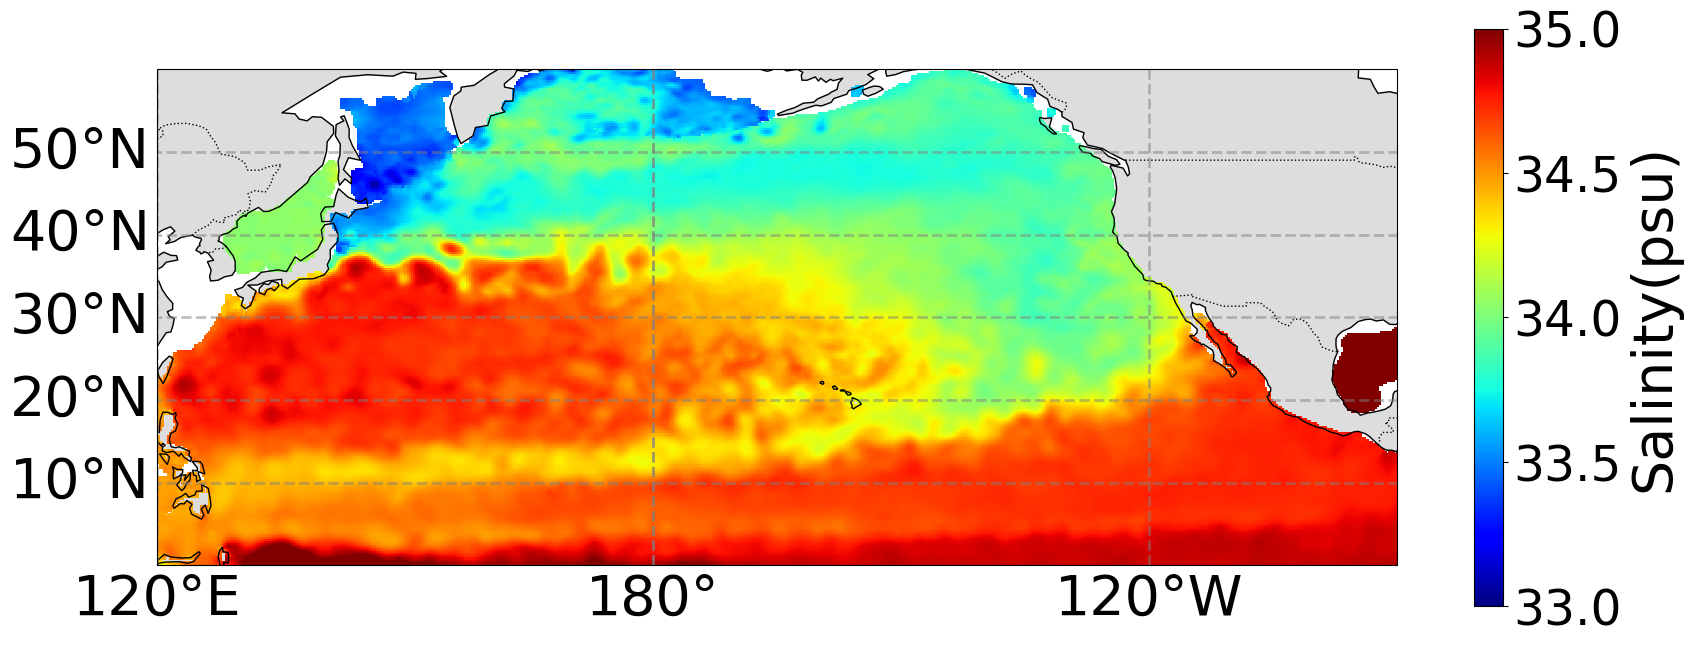

In [37]:
def draw(time, depth ,vmin,vmax):
#     longitude = lon_3dt[480-5:1080+5] # 经度变量名
#     latitude = lat_3dt[329-5:329+240+5] # 纬度变量名
    longitude = lon_3dt[480:1080] # 经度变量名
    latitude = lat_3dt[329:329+240] # 纬度变量名

    # 选择第一个时间点的温度数据进行绘图
    sta_one = sali_depth_use[time,19:-19,19:-19,depth]

    # 创建一个图和坐标轴
    fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # 设置地图范围
    ax.set_extent([120,270, 0, 60], crs=ccrs.PlateCarree())

    # 添加网格线和标签
    gl = ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 40}
    gl.ylabel_style = {'size': 40}

    # 绘制海岸线、国界
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(cartopy.feature.LAND, color='#dddddd')

    # 投影温度数据
    lon, lat = np.meshgrid(longitude, latitude)
    cs = ax.pcolormesh(lon, lat, np.squeeze(sta_one), cmap='jet', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(),shading='auto')

    # 添加色标
    cbar = plt.colorbar(cs, orientation='vertical', pad=0.05, aspect=20,shrink=0.5)
    cbar.set_label('Salinity(psu)', fontsize=40)
    cbar.ax.tick_params(labelsize=35)


    plt.show()
draw(130, 17,33,35)

### 计算3DSA次表层盐度异常

In [38]:
sali_depth_use.shape

(132, 278, 638, 33)

In [39]:
# 计算3DT 气候学
cli_3DS = sali_depth_use   #(132, 250, 610, 15)
#cli_3DT = temp_depth_use.reshape(11, 12, 250, 610, 33)    
cli_3DS = np.nanmean(cli_3DS,axis = 0)
print('次表层温度平均值',cli_3DS.shape)

次表层温度平均值 (278, 638, 33)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6596\3126870993.py:4: RuntimeWarning: Mean of empty slice
  cli_3DS = np.nanmean(cli_3DS,axis = 0)


In [40]:
#exp_cli_3DT = np.tile(cli_3DT,(11,1,1,1))  #沿第一个轴重复11次，在其他轴上不进行重复
A_3DS = sali_depth_use - cli_3DS

In [41]:
depth = [5,10,15,20,30,40,50,60,70,80,90,100,125,150,175,200,225,250,275,300,350,400,500,600,700,800,900,1000,1100,
              1300,1500,1750,2000]
depth[10]

90

In [42]:
# def draw(time, depth ,vmin,vmax):
# #     longitude = lon_3dt[480-5:1080+5] # 经度变量名
# #     latitude = lat_3dt[329-5:329+240+5] # 纬度变量名
#     longitude = lon_3dt[480:1080] # 经度变量名
#     latitude = lat_3dt[329:329+240] # 纬度变量名

#     # 选择第一个时间点的温度数据进行绘图
#     sta_one = A_3DT[time,5:-5,5:-5,depth]

#     # 创建一个图和坐标轴
#     fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

#     # 设置地图范围
#     ax.set_extent([120,270, 0, 60], crs=ccrs.PlateCarree())

#     # 添加网格线和标签
#     gl = ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
#     gl.top_labels = False
#     gl.right_labels = False
#     gl.xlabel_style = {'size': 40}
#     gl.ylabel_style = {'size': 40}

#     # 绘制海岸线、国界
#     ax.coastlines()
#     ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
#     ax.add_feature(cartopy.feature.LAND, color='#dddddd')

#     # 投影温度数据
#     lon, lat = np.meshgrid(longitude, latitude)
#     cs = ax.pcolormesh(lon, lat, np.squeeze(sta_one), cmap='jet', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(),shading='auto')

#     # 添加色标
#     cbar = plt.colorbar(cs, orientation='vertical', pad=0.05, aspect=20,shrink=0.5)
#     cbar.set_label('Temperature (°C)', fontsize=40)
#     cbar.ax.tick_params(labelsize=35)


#     plt.show()
# draw(59, 30,-0.2,0.2)

### 查看cli_3DS

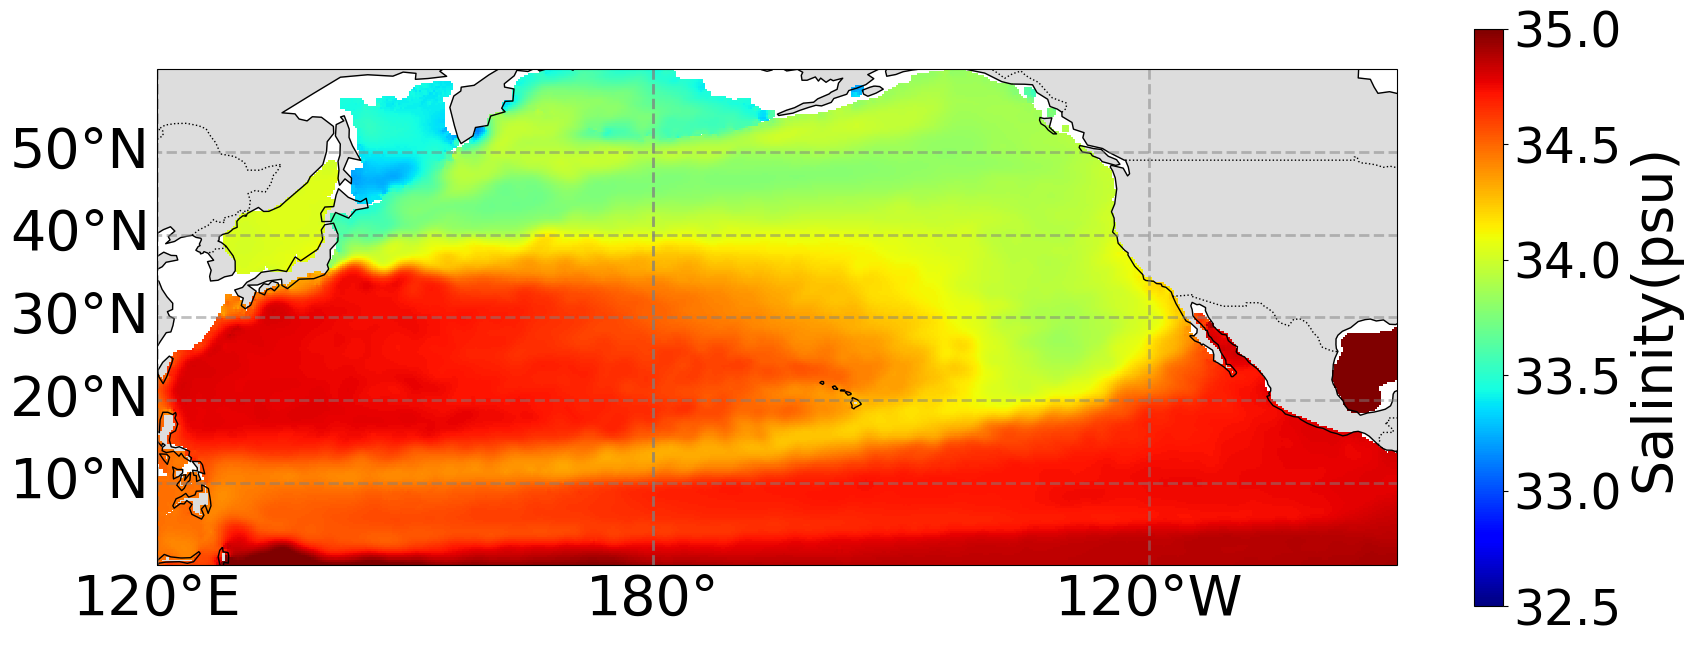

In [43]:
def draw(time, depth ,vmin,vmax):
#     longitude = lon_3dt[480-5:1080+5] # 经度变量名
#     latitude = lat_3dt[329-5:329+240+5] # 纬度变量名
    longitude = lon_3dt[480:1080] # 经度变量名
    latitude = lat_3dt[329:329+240] # 纬度变量名

    # 选择第一个时间点的温度数据进行绘图
    sta_one = cli_3DS[19:-19,19:-19,depth]

    # 创建一个图和坐标轴
    fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # 设置地图范围
    ax.set_extent([120,270,0,60], crs=ccrs.PlateCarree())

    # 添加网格线和标签
    gl = ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 40}
    gl.ylabel_style = {'size': 40}

    # 绘制海岸线、国界
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(cartopy.feature.LAND, color='#dddddd')

    # 投影温度数据
    lon, lat = np.meshgrid(longitude, latitude)
    cs = ax.pcolormesh(lon, lat, np.squeeze(sta_one), cmap='jet', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(),shading='auto')

    # 添加色标
    cbar = plt.colorbar(cs, orientation='vertical', pad=0.05, aspect=20,shrink=0.5)
    cbar.set_label('Salinity(psu)', fontsize=40)
    cbar.ax.tick_params(labelsize=35)


    plt.show()
draw(376, 17,32.5,35)

### 查看A_3DS

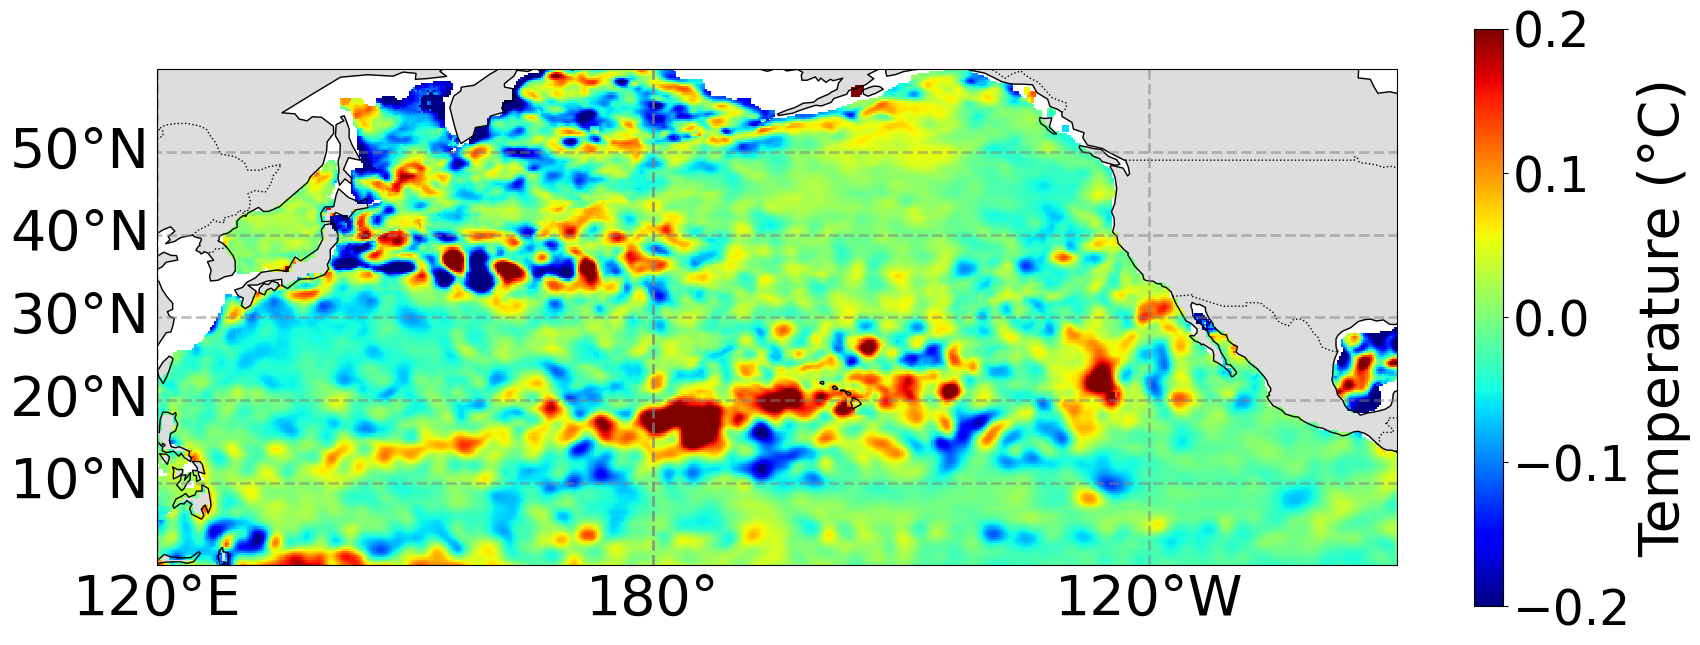

In [44]:
def draw(time, depth ,vmin,vmax):
#     longitude = lon_3dt[480-5:1080+5] # 经度变量名
#     latitude = lat_3dt[329-5:329+240+5] # 纬度变量名
    longitude = lon_3dt[480:1080] # 经度变量名
    latitude = lat_3dt[329:329+240] # 纬度变量名

    # 选择第一个时间点的温度数据进行绘图
    sta_one = A_3DS[time,19:-19,19:-19,depth]

    # 创建一个图和坐标轴
    fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # 设置地图范围
    ax.set_extent([120,270, 0, 60], crs=ccrs.PlateCarree())

    # 添加网格线和标签
    gl = ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 40}
    gl.ylabel_style = {'size': 40}

    # 绘制海岸线、国界
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(cartopy.feature.LAND, color='#dddddd')

    # 投影温度数据
    lon, lat = np.meshgrid(longitude, latitude)
    cs = ax.pcolormesh(lon, lat, np.squeeze(sta_one), cmap='jet', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(),shading='auto')

    # 添加色标
    cbar = plt.colorbar(cs, orientation='vertical', pad=0.05, aspect=20,shrink=0.5)
    cbar.set_label('Temperature (°C)', fontsize=40)
    cbar.ax.tick_params(labelsize=35)


    plt.show()
draw(0, 17,-0.2,0.2)

In [47]:
np.save("D:/codeFile/jupyterDemo/3d_ts/CNN-LSTM/code/天数据代码/天数据6_文件保存/3DS气候态/cli_3DS.npy",cli_3DS)

## SST表面温度数据

In [ ]:
data_sst = nc.Dataset(r'D:/data/SST/SST_2011-2021_month_sheshidu_interp.nc')

In [ ]:
# 确定时间
time_sst = data_sst['time'][:]
print(len(time_sst))

In [ ]:
lat_sst = data_sst['lat'][:].data
#print(lat_sst[360:600])             #0.125 --- 59.875
lon_sst = data_sst['lon'][:].data
# print(lon_sst[720+480:])             #120.125 --- 179.875
# print(lon_sst[:360])                 #179.875 --- -90.125

In [ ]:
sst = np.concatenate((data_sst['sst'][:,360-extend_num:600+extend_num,1200-extend_num:].data,data_sst['sst'][:,360-extend_num:600+extend_num,:360+extend_num].data),axis=2)

In [ ]:
print(sst.shape)
print(np.nanmax(sst),np.nanmin(sst))
print(np.sum(np.isnan(sst[5:6,:,:])))

### 计算STA表面温度异常

In [ ]:
# 计算sst 气候学
cli_sst = sst
#cli_sst = sst.reshape(11,12,250,610)
cli_sst = np.nanmean(cli_sst,axis=0)

In [ ]:
print('表面温度平均值',cli_sst.shape)

In [ ]:
#exp_cli_sst = np.tile(cli_sst, (11, 1, 1))
sta = sst - cli_sst 
print(sta.shape)

## 盐度差值

### 计算表面盐度平均值与深度盐度平均值

In [ ]:
sss.shape 

In [ ]:
sali_depth_use[:120].shape

In [ ]:
# 将填充值替换为nan
mean_3DS = sali_depth_use[:120]
mean_3DS[mean_3DS == 32767] = np.nan
mean_sss = sss[:120]
mean_sss[mean_sss == 32767] = np.nan

In [ ]:
# 重构数组
mean_3DS = mean_3DS.reshape(10, 12, 278, 638, 33)    #(132, 250, 610, 15)   --->(11，12, 250, 610, 15)  
mean_sss = mean_sss.reshape(10, 12, 278, 638)

#沿年份维度（即第一个维度）计算平均值
mean_3DS = np.nanmean(mean_3DS, axis=0)
print('水下盐度平均值：',mean_3DS.shape)

mean_sss = np.mean(mean_sss, axis=0)
print('表面盐度平均值：',mean_sss.shape)

### 表面盐度的平均值  减去 0-1000m盐度的平均值

In [ ]:
print('平均值形状：',mean_sss.shape,mean_3DS.shape)
mean_sss = np.expand_dims(mean_sss,axis=-1)         #扩展维度 
mean_sss = np.repeat(mean_sss, repeats=33,axis=-1)  #(12, 250, 610)  --》(12, 250, 610，33)  
mean_different = mean_sss - mean_3DS
print(mean_different.shape)

### 得到温度异常差

In [ ]:
repeated_mean_different = np.expand_dims(mean_different,axis=0)
repeated_mean_different = np.tile(repeated_mean_different, (11, 1, 1, 1, 1))
repeated_mean_different = repeated_mean_different.reshape(132, 278, 638,33)
print(repeated_mean_different.shape)

In [ ]:
repeated_sss = np.expand_dims(sss,axis=-1)
repeated_sss = np.tile(repeated_sss, (1, 1, 1, 33))

In [ ]:
dsss = repeated_sss - repeated_mean_different

In [ ]:
dsssa = dsss-cli_3DS

In [ ]:
depth[27:]

In [ ]:
dsssa_lay1 = np.mean(dsssa[:,:,:,:16],axis=-1)    #0-200m
dsssa_lay2 = np.mean(dsssa[:,:,:,15:28],axis=-1)   #200-1000m
dsssa_lay3 = np.mean(dsssa[:,:,:,27:],axis=-1)    #1000m-2000m

In [ ]:
dsss.shape,sali_depth_use.shape

# 数据预处理

## 数据合并

In [ ]:
print(ssha.shape,sssa.shape,uwnda.shape,vwnda.shape,sta.shape)
cat_surface =np.stack((ssha,sssa,uwnda,vwnda,sta,dsssa_lay1,dsssa_lay2,dsssa_lay3),axis=3)
print('表面数据：',cat_surface.shape)

# 将表面数据和水下数据在最后一个维度拼接，将空值删除。
cat_surface_depth = np.concatenate((cat_surface,A_3DS),axis=-1)
print('拼接后数据的形状：',cat_surface_depth.shape)

## 将填充值赋值为Nan
且一个点中有一个维度为nan,则将这个点的所有维度都设置为nan

### 塑形，将长*宽放在前面

In [ ]:
## 先对合并的数据进行reshape成（长*宽，时间*通道）
cat_surface_depth_reshape  = np.transpose(cat_surface_depth,(1,2,0,3))   # (132, 240, 600, 20) ---》 (240, 600, 132, 20)
print(cat_surface_depth_reshape.shape)
cat_surface_depth_reshape = cat_surface_depth_reshape.reshape ((-1,132*41))  # (240, 600, 132, 20) ---》(240*600, 132*20)
print(cat_surface_depth_reshape.shape)

### 一个点中只要有一个维度为nan,则将这个点的所有维度都设置为nan 

In [ ]:
# # 将填充值赋值为nan
# cat_data_ss_depth_reshape[cat_data_ss_depth_reshape == 32767] = np.nan
nan_mask = np.isnan(cat_surface_depth_reshape)

# nan_mask.any(axis=1)==true,只要第一个维度中含有nan就将所有设置为nan   (维度从0开始算起)
cat_surface_depth_reshape[nan_mask.any(axis=1) == True] = np.nan   
print('cat_surface_depth_reshape:',cat_surface_depth_reshape.shape)

### 将处理好的数据进行形状转化
(152500, 2640) --》(132, 250, 610, 20)

In [ ]:
#转化形状
cat_surface_depth_reshape = cat_surface_depth_reshape.reshape(-1,132,41)
print(cat_surface_depth_reshape.shape)
cat_surface_depth_reshape = np.transpose(cat_surface_depth_reshape,(1,0,2))
print(cat_surface_depth_reshape.shape)
cat_surface_depth_reshape = cat_surface_depth_reshape.reshape(-1,278, 638,41)
print(cat_surface_depth_reshape.shape)

In [ ]:
np.sum(np.isnan(cat_surface_depth_reshape[5:6,:,:,2:3]))

## 将数据分成小块

In [ ]:
cat_surface_depth_reshape = np.nan_to_num(cat_surface_depth_reshape,nan=0)

In [ ]:
# 表面数据
cat_data_ss = cat_surface_depth_reshape[:,:,:,:8]
# 深度数据
cat_data_depth = cat_surface_depth_reshape[:,:,:,8:]
print(cat_data_ss.shape,cat_data_depth.shape)

In [ ]:
print(np.sum(np.isnan(cat_data_depth[1:2,:,:,5:6])))
# 查看差值的形状

In [ ]:
cat_data_ss_float16 = cat_data_ss.astype(np.float16)

### 移动滑块将数据处理成小块

In [ ]:
# 移动滑块

import numpy as np
import pandas as pd
box_size = 39
def move_slider():
    time_size, lat_size, lon_size, channel = cat_data_ss.shape   # （132，250，610，5）

    # 定义矩形框的大小和步幅           
    #box_size = 39  # 单位为度
    step_size = 1  # 滑动步幅

    # 计算输出网格的形状
    out_lat_size = (lat_size - box_size) // step_size  + 1 
    out_lon_size = (lon_size - box_size) // step_size  + 1 

    print('time_size:',time_size,'lat_size:',lat_size,'lon_size:',lon_size)   #(132 280 600)
    print('out_lat_size:',out_lat_size,'out_lon_size:',out_lon_size)  #(240 600)

    #输出数组 
    out_data = np.zeros((time_size, out_lat_size , out_lon_size, (box_size+1)//2, (box_size+1)//2, channel),dtype=np.float16) #(132, 240, 600, 9,9,5)
    out_data_y = np.zeros((time_size, out_lat_size , out_lon_size, 33),dtype=np.float32) #(132, 272, 592,16)
    out_data_lstm = np.zeros((time_size, out_lat_size , out_lon_size, channel),dtype=np.float32)

    #========================CNN out_data =============================#
    #遍历时间步、纬度和经度
    for t in range(time_size):
        sample_idx = 0
        for lat in range(0, lat_size - box_size +1, step_size):
            for lon in range(0, lon_size - box_size +1  , step_size):
                # 计算当前矩形框的边界
                lat_min = lat
                lat_max = lat + box_size
                lon_min = lon
                lon_max = lon + box_size
                #print(lat_min,lat_max,lon_min,lon_max)
                # 获取当前矩形框的地图数据
                box_data = cat_data_ss_float16[t, lat_min:lat_max:2, lon_min:lon_max:2,:]
                out_data[t,lat,lon, :, :, :] = box_data
                box_data = []
                # 增加样本计数器
                sample_idx += 1
    print('out_data的形状',out_data.shape)


    #======================LSTM 与 y out_data==========================#   

    # 遍历时间步、纬度和经度
    shift = (box_size-1)//2
    for t in range(time_size):
        sample_idx = 0
        for lat in range(shift, lat_size-shift, step_size):
            for lon in range(shift, lon_size-shift, step_size):
                out_data_y[t,lat-shift,lon-shift, :] = cat_data_depth[t, lat:lat+1, lon:lon+1,:]
                out_data_lstm[t,lat-shift,lon-shift, :] = cat_data_ss[t, lat:lat+1, lon:lon+1,:] 
                #print(sample_idx)
                # 增加样本计数器
                sample_idx += 1

    print('out_data_y的形状',out_data_y.shape)
    print('out_data_lstm的形状',out_data_lstm.shape)   
    # out_data_reshape = slider_value(cat_data)


    return out_data,out_data_y,out_data_lstm
    

In [ ]:
out_data,out_data_y,out_data_lstm = move_slider()

## 删除缺失值多于一半的数据

### 获取Nan_mask

In [ ]:
# 修改变量形状,修改成(时间，个数，长，宽，通道)
out_data_reshape = out_data.reshape((132,-1,(box_size+1)//2,(box_size+1)//2,8))
print(out_data_reshape.shape) 

In [ ]:
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape[0,:,:,:,0])
print(nan_mask_out_data.shape)

In [ ]:
# （137344，9，9）中存在4500416个nan
print(np.count_nonzero(nan_mask_out_data))

In [ ]:
# 选取一个作为代表. 其中true 代表Nan
nan_mask_out_data_one = nan_mask_out_data.reshape(-1,(box_size+1)//2*(box_size+1)//2) 
nan_mask_out_data_one.shape 

#### 为有效值大于一半的方块标注True

In [ ]:
(nan_mask_out_data_one.shape[-1]//2)

In [ ]:
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=(nan_mask_out_data_one.shape[-1]//2)):    #True 代表nan，当nan小于等于61时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)

# 查看有效值个数
np.count_nonzero(nan_mask)  

#### 标注lstm中的缺失值

In [ ]:
out_data_lstm.shape 

In [ ]:
## 标注lstm中的缺失值
out_data_lstm_reshape = out_data_lstm.reshape((132,-1,8))
print(out_data_lstm_reshape.shape)
# 获取变量 nan 掩码
nan_mask_lstm = np.isnan(out_data_lstm_reshape)
print(nan_mask_lstm.shape)

In [ ]:
np.count_nonzero(~nan_mask_lstm[0,:,3])     # 105773 这个数不变

#### 合并缺失值

In [ ]:
nan_mask_cat = [a and b for a, b in zip(nan_mask, ~nan_mask_lstm[0,:,0])]
# 返回非零元素个数，即有效值个数
print(np.count_nonzero(nan_mask_cat))  

In [ ]:
# nan_mask_cat = ~nan_mask_lstm[0,:,0]
len(nan_mask_cat)

#### 保存数据/加载数据

In [ ]:
#np.save("../model/lstm_transformer/mask/zt+ys_sali_mask.npy",nan_mask_cat)

In [ ]:
nan_mask_cat = np.load("../model/lstm_transformer/mask/zt+ys_sali_mask.npy")

### 修改数据形状，使其可以通过nan_mask_cat删除无效数据

In [ ]:
# 重塑形状用于删除无效值
out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)

out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
print('out_data_y_reshape:',out_data_y_reshape.shape)
out_data_y_reshape = out_data_y_reshape.reshape(-1,132,33)
print('out_data_y_reshape:',out_data_y_reshape.shape)

out_data_lstm_reshape =  np.transpose(out_data_lstm,(1,2,0,3))
print('out_data_lstm_reshape:',out_data_lstm_reshape.shape)
out_data_lstm_reshape = out_data_lstm_reshape.reshape(-1,132,8)
print('out_data_lstm_reshape:',out_data_lstm_reshape.shape) 

### 开始删除无效数据

In [ ]:
out_data_reshape = out_data_reshape[nan_mask_cat]
out_data_y_reshape = out_data_y_reshape[nan_mask_cat]
out_data_lstm_reshape = out_data_lstm_reshape[nan_mask_cat]
   
# out_data_mean_abnormal_different_cnn_reshape = out_data_mean_abnormal_different_cnn_reshape[nan_mask_cat]
# out_data_mean_abnormal_different_lstm_reshape = out_data_mean_abnormal_different_lstm_reshape[nan_mask_cat]

In [ ]:
del out_data
gc.collect()

### 使用0来填充Nan

In [ ]:
# out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103952, 132, 9, 9, 5) 
# out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103952, 132, 15)
# out_data_lstm_reshape = np.nan_to_num(out_data_lstm_reshape, nan=0)

# 验证集和测试集的划分

## 对数据进行reshape,以进行数据集的划分

In [ ]:
# 将时间放到前面
out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)
out_data_lstm_reshape =  np.transpose(out_data_lstm_reshape,(1,0,2))
print('out_data_lstm_reshape:',out_data_lstm_reshape.shape)
# out_data_mean_abnormal_different_cnn_reshape = np.transpose(out_data_mean_abnormal_different_cnn_reshape,(1,0,2,3,4))
# print('out_data_mean_abnormal_different_cnn_reshape',out_data_mean_abnormal_different_cnn_reshape.shape)
# out_data_mean_abnormal_different_lstm_reshape = np.transpose(out_data_mean_abnormal_different_lstm_reshape,(1,0,2))
# print('out_data_mean_abnormal_different_lstm_reshape',out_data_mean_abnormal_different_lstm_reshape.shape)

## 将数据进行堆叠

In [ ]:
available = len(out_data_lstm_reshape) 
predict = 1

out_data_lstm_reshape_shape = out_data_lstm_reshape.shape[1:]
N_stack = 12
X_len = available - (N_stack-1)

X_lstm = np.zeros(shape = (X_len, N_stack,out_data_lstm_reshape_shape[0],out_data_lstm_reshape_shape[1]))  
for i in range(X_len):
    X_lstm[i] = np.stack(out_data_lstm_reshape[i:i+N_stack])
    #print(i)

print(X_lstm.shape)
#print(Y.shape)

## 统一时间

In [ ]:
Y = out_data_y_reshape[11:]
X_cnn = out_data_reshape[11:]
# X_cnn_different = end_cnn_different[9:]
# print(X_lstm.shape,Y.shape,X_cnn.shape,X_cnn_different.shape,X_lstm_different.shape)

In [ ]:
print(Y.shape)

## 划分数据集

In [ ]:
# 最后十二个月的数据作为test
test_num = -12
x_cnn_train = X_cnn[:test_num]
x_lstm_train = X_lstm[:test_num]
y_train = Y[:test_num]

x_cnn_test = X_cnn[test_num:]
x_lstm_test = X_lstm[test_num:]
y_test = Y[test_num:]

print(x_cnn_train.shape,x_lstm_train.shape,y_train.shape,x_cnn_test.shape,x_lstm_test.shape,y_test.shape)

In [ ]:
#将前两个维度进行合并  时间*(lat*lon) = batchsize

x_cnn_train = np.reshape(x_cnn_train,(-1,(box_size+1)//2,(box_size+1)//2,x_cnn_train.shape[-1]))
x_cnn_test = np.reshape(x_cnn_test,(-1,(box_size+1)//2,(box_size+1)//2,x_cnn_train.shape[-1]))

y_train = np.reshape(y_train,(-1,33))
y_test = np.reshape(y_test,(-1,33))

x_lstm_train = np.transpose(x_lstm_train, (0,2,1,3))  # (115, 6, 103623, 5)  ---> (115, 103623, 6, 5)
x_lstm_train = x_lstm_train.reshape((-1,N_stack,8))          #(115, 103623, 6, 5)  ----->(115*103623, 6, 5)
x_lstm_test = np.transpose(x_lstm_test, (0,2,1,3))
x_lstm_test = x_lstm_test.reshape((-1,N_stack,8))

In [ ]:
# 查看形状
print('x_lstm_train',x_lstm_train.shape)
print('x_cnn_train',x_cnn_train.shape)
print('y_train',y_train.shape)

print('x_cnn_test:',x_cnn_test.shape)
print('x_lstm_test:',x_lstm_test.shape)
print('y_test',y_test.shape)

## 划分训练数据和目标数据

In [ ]:
x_cnn_train_split, x_cnn_val, y_train_split, y_val = train_test_split(x_cnn_train , y_train, test_size=0.3, random_state=100)
x_lstm_train_split, x_lstm_val, y_train_split_2, y_val_2 = train_test_split(x_lstm_train, y_train, test_size=0.3, random_state=100)

In [ ]:
# 输出形状
print('x_cnn_train_split',x_cnn_train_split.shape)
print('x_lstm_train_split',x_lstm_train_split.shape)
print('y_train_split',y_train_split_2.shape)

print('x_cnn_test',x_cnn_test.shape)
print('x_lstm_test',x_lstm_test.shape)
print('y_test',y_test.shape)

print('x_cnn_val',x_cnn_val.shape)
print('x_lstm_val',x_lstm_val.shape)
print('y_val',y_val_2.shape)

In [ ]:
del X_cnn,out_data_reshape
gc.collect()

# 特征归一化

In [ ]:
# 记录数据集的形状
# train 
x_cnn_train_split_shape = x_cnn_train_split.shape
x_lstm_train_split_shape = x_lstm_train_split.shape 
y_train_split_shape  = y_train_split_2.shape

# test 
x_cnn_test_shape = x_cnn_test.shape
x_lstm_test_shape = x_lstm_test.shape
y_test_shape = y_test.shape

#val
x_cnn_val_shape = x_cnn_val.shape
x_lstm_val_shape = x_lstm_val.shape
y_val_shape = y_val_2.shape

In [ ]:
x_cnn_train_split_shape[3]

In [ ]:
x_cnn_train_split.dtype

In [ ]:
# 变量标准化
scaler_f = StandardScaler()
scaler_f_2 = StandardScaler()
x_cnn_train_split = scaler_f.fit_transform(x_cnn_train_split.reshape(-1,x_cnn_train_split_shape[3])) 
x_lstm_train_split = scaler_f_2.fit_transform(x_lstm_train_split.reshape(-1,x_lstm_train_split_shape[2])) 

x_cnn_test = scaler_f.transform(x_cnn_test.reshape(-1,x_cnn_test_shape[3]))
x_lstm_test = scaler_f_2.transform(x_lstm_test.reshape(-1,x_lstm_test_shape[2]))

x_cnn_val = scaler_f.transform(x_cnn_val.reshape(-1,x_cnn_val_shape[3]))
x_lstm_val = scaler_f_2.transform(x_lstm_val.reshape(-1,x_lstm_val_shape[2]))

In [ ]:
# 目标值标准化
scaler_l = StandardScaler()
y_train_split = scaler_l.fit_transform(y_train_split_2.reshape(-1,y_train_split_shape[1])) 
y_test = scaler_l.transform(y_test.reshape(-1,y_test_shape[1])) 
y_val = scaler_l.transform(y_val_2.reshape(-1,y_val_shape[1])) 

In [ ]:
box_size

In [ ]:
#reshape
x_cnn_train_split = np.reshape(x_cnn_train_split,(-1,(box_size+1)//2,(box_size+1)//2,8))
x_cnn_test = np.reshape(x_cnn_test,(-1,(box_size+1)//2,(box_size+1)//2,8))
x_cnn_val = np.reshape(x_cnn_val,(-1,(box_size+1)//2,(box_size+1)//2,8))


x_lstm_train_split = np.reshape(x_lstm_train_split,(-1,N_stack,8))
x_lstm_test = np.reshape(x_lstm_test,(-1,N_stack,8))
x_lstm_val = np.reshape(x_lstm_val,(-1,N_stack,8))


y_train_split = np.reshape(y_train_split,(-1,33))
y_test = np.reshape(y_test,(-1,33))
y_val = np.reshape(y_val,(-1,33))

In [ ]:
# 输出形状
print('x_cnn_train_split',x_cnn_train_split.shape)
print('x_lstm_train_split',x_lstm_train_split.shape)
print('y_train_split',y_train_split.shape)

print('x_cnn_test',x_cnn_test.shape)
print('x_lstm_test',x_lstm_test.shape)
print('y_test',y_test.shape)

print('x_cnn_val',x_cnn_val.shape)
print('x_lstm_val',x_lstm_val.shape)
print('y_val',y_val.shape)

In [ ]:
0/0

# 定义网络结构

## transformer

In [ ]:
#@save   masked_softmax
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return tf.nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if len(valid_lens.shape) == 1:
            valid_lens = tf.repeat(valid_lens, repeats=shape[1])

        else:
            valid_lens = tf.reshape(valid_lens, shape=-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(tf.reshape(X, shape=(-1, shape[-1])),
                              valid_lens, value=-1e6)
        return tf.nn.softmax(tf.reshape(X, shape=shape), axis=-1)

In [ ]:
#@save 形状转化
def transpose_qkv(X, num_heads):

    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    #print('开始转化')
    #print(X.shape)
    #print(X.shape[2],X.shape[2]/num_heads)
    X = tf.reshape(X,shape=(-1, X.shape[1], num_heads, int(X.shape[2]/num_heads)))
    #print('转化完成')
    #print(X.shape)
    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = tf.transpose(X, perm=(0, 2, 1, 3))

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return tf.reshape(X, shape=(-1, X.shape[2], X.shape[3]))
#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = tf.reshape(X, shape=(-1, num_heads, X.shape[1], X.shape[2]))
    X = tf.transpose(X, perm=(0, 2, 1, 3))
    return tf.reshape(X, shape=(-1, X.shape[1],X.shape[2]*X.shape[3]))

In [ ]:
#@save   缩放点击注意力
class DotProductAttention(tf.keras.layers.Layer):
    """Scaleddotproductattention."""
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def call(self, queries, keys, values, valid_lens, **kwargs):
        d = queries.shape[-1]
        scores = tf.matmul(queries, keys, transpose_b=True)/tf.math.sqrt(
            tf.cast(d, dtype=tf.float32))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return tf.matmul(self.dropout(self.attention_weights, **kwargs), values)

In [ ]:
#@save   多头注意力
class MultiHeadAttention_my(tf.keras.layers.Layer):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.key_size = key_size
        self.query_size = query_size
        self.value_size = value_size
        self.num_hiddens = num_hiddens
        self.dropout = dropout
        self.bias = bias
        self.attention = DotProductAttention(dropout)
        self.W_q = tf.keras.layers.Dense(num_hiddens, use_bias=bias)
        self.W_k = tf.keras.layers.Dense(num_hiddens, use_bias=bias)
        self.W_v = tf.keras.layers.Dense(num_hiddens, use_bias=bias)
        self.W_o = tf.keras.layers.Dense(num_hiddens, use_bias=bias)
        #print('初始化完成')

    def call(self, queries, keys, values, valid_lens, **kwargs):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        
        #print(1)
        #print('queries.shape',queries.shape)
        #print('queries.type',type(queries))
        #self.W_q(queries)
        #print(1.1)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        #print(2)
        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = tf.repeat(valid_lens, repeats=self.num_heads, axis=0)
        #print(123)
        # output的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        #print('准备开始计算')
        output = self.attention(queries, keys, values, valid_lens, **kwargs)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)
    
    def get_config(self):
        return{'num_heads': self.num_heads,
                'key_size': self.key_size,
                'query_size': self.query_size,
                'value_size': self.value_size,
                'num_hiddens': self.num_hiddens,
                'dropout': self.dropout,
                'bias': self.bias}

In [ ]:
#@save   基于位置的前馈网络
class PositionWiseFFN(tf.keras.layers.Layer):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super().__init__(*kwargs)
        self.ffn_num_hiddens = ffn_num_hiddens
        self.ffn_num_outputs = ffn_num_outputs
        self.dense1 = tf.keras.layers.Dense(ffn_num_hiddens)
        self.relu = tf.keras.layers.ReLU()
        self.dense2 = tf.keras.layers.Dense(ffn_num_outputs)

    def call(self, X):
        return self.dense2(self.relu(self.dense1(X)))
    def get_config(self):
        return{'ffn_num_hiddens': self.ffn_num_hiddens,
                'ffn_num_outputs': self.ffn_num_outputs
              }

In [ ]:
#@save   残差连接后进行规范化
class AddNorm(tf.keras.layers.Layer):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__(**kwargs)
        self.normalized_shape = normalized_shape
        self.dropout = dropout
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.ln = tf.keras.layers.LayerNormalization(normalized_shape)   # 沿着通道维度进行归一化

    def call(self, X, Y, **kwargs):
        return self.ln(self.dropout(Y, **kwargs) + X)
    
    def get_config(self):
        return{'normalized_shape': self.normalized_shape,
                'dropout': self.dropout
              }

In [ ]:
#@save   位置编码
class PositionalEncoding(tf.keras.layers.Layer):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.dropout = tf.keras.layers.Dropout(dropout)
        # 创建一个足够长的P
        self.P = np.zeros((1, max_len, num_hiddens))
        X = np.arange(max_len, dtype=np.float32).reshape(
            -1,1)/np.power(10000, np.arange(
            0, num_hiddens, 2, dtype=np.float32) / num_hiddens)
        self.P[:, :, 0::2] = np.sin(X)
        self.P[:, :, 1::2] = np.cos(X)

    def call(self, X, **kwargs):
        X = X + self.P[:, :X.shape[1], :]
        return self.dropout(X, **kwargs)
    
    def get_config(self):
        return{'num_hiddens': self.num_hiddens,
                'dropout': self.dropout
              }

In [ ]:
#通道注意力       
# class ChannelAttention(tf.keras.layers.Layer):     # 修改部分
#     def __init__(self, input_channels):
#         super(ChannelAttention, self).__init__()
#         # 使用一个简单的全连接层来学习每个通道的重要性
#         self.input_channels = input_channels
#         self.fc = tf.keras.layers.Dense(input_channels, activation='relu')

#     def call(self, x):
#         # x的形状: (batch_size, channels)
#         attention_weights = self.fc(x)  # 生成通道权重
#         attention_weights = tf.keras.layers.Activation('softmax')(attention_weights)  # 归一化权重
#         weighted_output = x * attention_weights  # 加权输入
#         return weighted_output
    
#     def get_config(self):
#         return{'input_channels': self.input_channels}
    
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, input_channels):
        super(ChannelAttention, self).__init__()
        # 使用一个简单的全连接层来学习每个通道的重要性
        self.input_channels = input_channels
        self.fc1 = layers.Dense(input_channels//4, kernel_initializer='he_normal',
                                kernel_regularizer=regularizers.l2(5e-4),
                                activation=tf.nn.relu,
                                use_bias=True, bias_initializer='zeros')
        self.fc2 = layers.Dense(input_channels, kernel_initializer='he_normal',
                                kernel_regularizer=regularizers.l2(5e-4),
                                use_bias=True, bias_initializer='zeros')

    def call(self, x):
        # x的形状: (batch_size, channels)
        attention_weights = self.fc2(self.fc1(x))  # 生成通道权重
        attention_weights = tf.keras.layers.Activation('softmax')(attention_weights)  # 归一化权重
        weighted_output = x * attention_weights  # 加权输入
        return weighted_output
    
    def get_config(self):
        return{'input_channels': self.input_channels}    

In [ ]:
##   时序特征增强块
def time_back(model_input):
    model1 = tf.keras.layers.Conv1D(32, 3,padding='causal')(model_input)
    model1 = tf.keras.layers.ReLU()(model1)
    model1 = Dropout(rate=0.2)(model1)
    
    model2 = tf.keras.layers.Conv1D(32, 3,padding='causal',dilation_rate=2)(model_input)
    model2 = tf.keras.layers.ReLU()(model2)
    model2 = Dropout(rate=0.2)(model2)
    
    model3 = tf.keras.layers.Conv1D(32,1)(model_input)
    
    model_cat = tf.keras.layers.Add()([model1, model2])

    model_lstm = tf.keras.layers.Bidirectional(LSTM(16, return_sequences=True))(model_cat) 
    model_lstm = tf.keras.layers.ReLU()(model_lstm)
    model_lstm = Dropout(rate=0.2)(model_lstm)
    
    model_output =  tf.keras.layers.Add()([model_lstm, model3])
    return model_output

In [ ]:
##   Transformer块
#@save    编码器块
class EncoderBlock(tf.keras.layers.Layer):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.key_size = key_size
        self.query_size = query_size
        self.value_size = value_size
        self.num_hiddens = num_hiddens
        self.norm_shape = norm_shape
        self.ffn_num_hiddens = ffn_num_hiddens
        self.num_heads = num_heads
        self.dropout = dropout
        self.bias = bias
        self.attention = MultiHeadAttention_my(key_size, query_size, value_size, num_hiddens,
                                                num_heads, dropout, bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)   #ffn_num_hiddens隐藏维度，num_hiddens输出维度
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def call(self, X, valid_lens, **kwargs):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens, **kwargs), **kwargs)
        return self.addnorm2(Y, self.ffn(Y), **kwargs)
    def get_config(self):
        return{
                'key_size': self.key_size,
                'query_size': self.query_size,
                'value_size': self.value_size,
                'num_hiddens': self.num_hiddens,
                'norm_shape': self.norm_shape,
                'ffn_num_hiddens': self.ffn_num_hiddens,
                'num_heads': self.num_heads,
                'dropout': self.dropout,
                'bias': self.bias,}

## transformer(CNN)

In [ ]:
#  通道注意力 #
class ChannelAttention_CNN(layers.Layer):
    def __init__(self, in_planes, ratio=2):  #修改部分：由2修改为了4
        super(ChannelAttention_CNN, self).__init__()
        self.avg_out= layers.GlobalAveragePooling2D()
        self.max_out= layers.GlobalMaxPooling2D()

        self.fc1 = layers.Dense(in_planes//ratio, kernel_initializer='he_normal',
                                kernel_regularizer=regularizers.l2(5e-4),
                                activation=tf.nn.relu,
                                use_bias=True, bias_initializer='zeros')
        self.fc2 = layers.Dense(in_planes, kernel_initializer='he_normal',
                                kernel_regularizer=regularizers.l2(5e-4),
                                use_bias=True, bias_initializer='zeros')

    def call(self,inputs):
        avg_out = self.avg_out(inputs)
        max_out = self.max_out(inputs)
        out = tf.stack([avg_out, max_out], axis=1)  # shape=(None, 2, fea_num)
        out = self.fc2(self.fc1(out))
        out = tf.reduce_sum(out, axis=1)             # shape=(256, 512)
        out = tf.nn.sigmoid(out)
        out = layers.Reshape((1, 1, out.shape[1]))(out)
        return out*inputs
# 空间注意力 #
def regularized_padded_conv(*args, **kwargs):
    return layers.Conv2D(*args, **kwargs, padding='same', use_bias=False,
                         kernel_initializer='he_normal',
                         kernel_regularizer=regularizers.l2(5e-4))

class SpatialAttention_CNN(layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention_CNN, self).__init__()
        self.conv1 = regularized_padded_conv(1, kernel_size=kernel_size, strides=1, activation='sigmoid')
    def call(self,inputs):
        avg_out = tf.reduce_mean(inputs, axis=3)
        max_out = tf.reduce_max(inputs, axis=3)
        out = tf.stack([avg_out, max_out], axis=-1)             # 创建一个维度,拼接到一起concat。
        out = self.conv1(out)
        return out*inputs

In [ ]:
#@save   卷积通道多头注意力
class MultiHeadAttention_my_ChannelAttention(tf.keras.layers.Layer):
    """多头注意力"""
    def __init__(self,input_size, num_hiddens,num_heads, dropout, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.num_hiddens = num_hiddens
        self.num_heads = num_heads
        self.dropout = dropout
        self.ChannelAttention_CNN = ChannelAttention_CNN(int(self.num_hiddens//self.num_heads))  # 输入通道数
        
        self.conv1 = Conv2D(filters=num_hiddens, kernel_size=(1, 1),strides=1,padding='same')   
        self.conv2 = Conv2D(filters=num_hiddens, kernel_size=(1, 1),strides=1,padding='same')

    def call(self, input_data, **kwargs):
        # 1.先经过卷积层，并修改维度
        queries = transpose_input_cnn(self.conv1(input_data),self.num_heads)
        #print('queries的形状为',queries.shape)

        # output的形状:(batch_size*num_heads，长，宽，num_hiddens/num_heads)
        # 2.进入注意力层
        output = self.ChannelAttention_CNN(queries)  
        
        # 3.将形状修改回来
        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output_cnn(output, self.num_heads)
        
        #4.通过最后的卷积层，并返回
        return self.conv2(output_concat)
    
    def get_config(self):
        return{'input_size': self.input_size,
                'num_hiddens': self.num_hiddens,
                'num_heads': self.num_heads,
                'dropout': self.dropout,}    

In [ ]:
#@save   卷积空间多头注意力
class MultiHeadAttention_my_SpatialAttention(tf.keras.layers.Layer):
    """多头注意力"""
    def __init__(self,input_size, num_hiddens,num_heads, dropout, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.num_hiddens = num_hiddens
        self.num_heads = num_heads
        self.dropout = dropout
        self.SpatialAttention_CNN =SpatialAttention_CNN()

        self.conv1 = Conv2D(filters=num_hiddens, kernel_size=(1, 1),strides=1,padding='same')   # 首先经过1*1和3*3 来捕获通道和空间特征
        self.conv2 = Conv2D(filters=num_hiddens, kernel_size=(1, 1),strides=1,padding='same')

    def call(self, input_data, **kwargs):
        # 1.先经过卷积层，并修改形状
        queries = transpose_input_cnn(self.conv1(input_data),self.num_heads)
         # 2.进入注意力层
        output = self.SpatialAttention_CNN(queries)  
         # 3.将形状修改回来
        output_concat = transpose_output_cnn(output, self.num_heads)
        #4.通过最后的卷积层，并返回
        return self.conv2(output_concat)
    
    def get_config(self):
        return{'input_size': self.input_size,
                'num_hiddens': self.num_hiddens,
                'num_heads': self.num_heads,
                'dropout': self.dropout,
               }    

In [ ]:
#@save 形状转化
def transpose_input_cnn(X, num_heads):

    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，长，宽，通道)
    # 输出X的形状:(batch_size，长，宽，num_heads，通道/num_heads)
    X = tf.reshape(X,shape=(-1, X.shape[1], X.shape[2], num_heads, int(X.shape[3]/num_heads)))
    #print('转化完成')
    #print(X.shape)
    # 输出X的形状:(batch_size，num_heads，长，宽，通道/num_heads)
    X = tf.transpose(X, perm=(0, 3, 1, 2, 4))

    # 最终输出的形状:(batch_size*num_heads,长，宽，通道/num_heads)
    return tf.reshape(X, shape=(-1, X.shape[2], X.shape[3],X.shape[4]))
#@save
def transpose_output_cnn(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    #(batch_size*num_heads,长，宽，通道/num_heads) ==>(batch_size，num_heads,长，宽，通道/num_heads) 
    X = tf.reshape(X, shape=(-1, num_heads, X.shape[1], X.shape[2], X.shape[3]))
    #print(X.shape)
    # 输出形状为 (batch_size，长，宽，num_heads，通道/num_heads) 
    X = tf.transpose(X, perm=(0, 2, 3, 1, 4))
    #print(X.shape)
    return tf.reshape(X, shape=(-1, X.shape[1],X.shape[2],X.shape[3]*X.shape[4]))

In [ ]:
# 深度可分离卷积
class DepthwiseSeparableConv(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        # 深度可分离卷积包括深度卷积和逐点卷积两个步骤
        self.depthwise = tf.keras.layers.DepthwiseConv2D(kernel_size=3, padding='same',strides=1, depth_multiplier=1)
        self.pointwise = tf.keras.layers.Conv2D(out_channels, kernel_size=1, padding='valid', strides=1)

    def call(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x
    def get_config(self):
        return{'in_channels': self.in_channels,
                'out_channels': self.out_channels}

In [ ]:
#@save   卷积前馈网络
class PositionWiseFFNCnn(tf.keras.layers.Layer):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super().__init__(*kwargs)
        self.ffn_num_hiddens = ffn_num_hiddens
        self.ffn_num_outputs = ffn_num_outputs
        self.conv1 = Conv2D(filters=ffn_num_hiddens, kernel_size=(1, 1),strides=1,padding='same')
        self.relu = tf.keras.layers.ReLU()
        #self.conv2 = DepthwiseSeparableConv(in_channels=ffn_num_hiddens, out_channels=ffn_num_outputs)
        self.conv2 = tf.keras.layers.SeparableConv2D(ffn_num_outputs, (3, 3), padding='same')   # 修改部分
        
    def call(self, X):
        return self.conv2(self.relu(self.conv1(X)))
    def get_config(self):
        return{'ffn_num_hiddens': self.ffn_num_hiddens,
                'ffn_num_outputs': self.ffn_num_outputs
              }

In [ ]:
#@save   残差连接后进行规范化
class AddNormCnn(tf.keras.layers.Layer):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__(**kwargs)
        self.normalized_shape = normalized_shape
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.ln = tf.keras.layers.LayerNormalization(normalized_shape)   # 沿着通道维度进行归一化

    def call(self, X, Y, **kwargs):
        return self.ln(self.dropout(Y, **kwargs) + X)
    
    def get_config(self):
        return{'normalized_shape': self.normalized_shape,
                'dropout': self.dropout
              }

In [ ]:
# CNN_transformer_Block
class EncoderBlockCnn(tf.keras.layers.Layer):
    def __init__(self, input_size, num_hiddens,norm_shape,ffn_num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.num_hiddens = num_hiddens
        self.ffn_num_hiddens = ffn_num_hiddens
        self.num_heads = num_heads
        self.dropout = dropout
        self.norm_shape = norm_shape
        
        self.mca = MultiHeadAttention_my_ChannelAttention(input_size,num_hiddens,num_heads,dropout)
        self.msa = MultiHeadAttention_my_SpatialAttention(input_size,num_hiddens,num_heads,dropout)
        self.addnorm1 = AddNormCnn(norm_shape,dropout)
        self.ffn = PositionWiseFFNCnn(ffn_num_hiddens,num_hiddens)  # 隐藏层，输出层
        self.addnorm2 = AddNormCnn(norm_shape,dropout)
        
    def call(self,X,**kwargs):
        Y = self.addnorm1(X, self.msa(self.mca(X)), **kwargs)
        return self.addnorm2(Y, self.ffn(Y), **kwargs)
    
    def get_config(self):
        return {'input_size': self.input_size,
                'num_hiddens': self.num_hiddens,
                'norm_shape': self.norm_shape,
                'ffn_num_hiddens': self.ffn_num_hiddens,
                'num_heads': self.num_heads,
                'dropout': self.dropout
              }

In [ ]:
# 空间特征增强块
def SpaceEnhanceBlock(model_input):
    x = Conv2D(filters=16, kernel_size=(1, 5),strides=1,padding='same')(model_input)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)
    
    x1 = Conv2D(filters=16, kernel_size=(5, 1),strides=1,dilation_rate=1,padding='same')(model_input)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    
    x3 = Conv2D(filters=32, kernel_size=(1, 1),strides=1,padding='same')(model_input)
    x3 = BatchNormalization()(x3)
    
    x_cat = tf.keras.layers.Add()([x,x1])
    x_cat = Activation('relu')(x_cat)
    #x4 = DepthwiseSeparableConv(in_channels=16, out_channels=32)(x_cat)     
    x4 = tf.keras.layers.SeparableConv2D(32, (3, 3), padding='same')(x_cat)
    x4 = BatchNormalization()(x4)
    x4 = Activation('relu')(x4)

    
    out = tf.keras.layers.Add()([x3,x4])
    return out

## 整体模型

In [ ]:
#整体模型  
def my_model_old():
    # ==========================时间序列部分==========================================================#
    model_input= Input(shape=(12,8))
    #1、时序特征增强块#
    model = time_back(model_input) 
    
    # 2、进行位置编码#
    # 因为位置编码值在-1和1之间，因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
    model = PositionalEncoding(32,0.2)(model * tf.math.sqrt(tf.cast(32, dtype=tf.float32)))
    
    # 3、transformer块#
    for _ in range(4): 
        model = EncoderBlock(32, 32, 32, 32, 2, 64, 8, 0.2)(model,None) # q,k,v 隐藏层，层归一化维度，
        model = Dropout(0.2)(model)
    
    # 4、得到输出 #
    model = Flatten()(model)
    model = Dense(64,activation='relu')(model)
    
    model_channel = ChannelAttention(64)(model)
    model_cat = tf.keras.layers.Add()([model, model_channel])
    model = tf.keras.layers.ReLU()(model_cat)
    
    out1 = Dense(33)(model)

    # ==========================空间部分==========================================================#
    model2_input= Input(shape=(20,20,8))
    #1. 空间特征增强块
    model2 = SpaceEnhanceBlock(model2_input)
    
    #2. 最大池化
    model2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(model2)
    
    #3. CNN_transformer块
    model2 = EncoderBlockCnn(32,32, -1, 32, 4, 0.2)(model2) # q 隐藏层，层归一化维度，
    model2 = Dropout(0.2)(model2)
    
    #4. 得到输出  
    model2 = Conv2D(filters=16, kernel_size=(3,3),strides=1)(model2)
    model2 = BatchNormalization()(model2)
    model2= ReLU()(model2)
    model2 = Conv2D(filters=8, kernel_size=(3,3),strides=1)(model2) 
    model2 = Flatten()(model2)
    out2 = Dense(33)(model2)
    
    # ==========================模型融合=========================================================#
    ensemble = Concatenate()([out1, out2])
    ensemble_out = Dense(128,activation='relu')(ensemble) 
    ensemble_out = Dropout(0.2)(ensemble_out)  # 添加Dropout层
    ensemble_channel = ChannelAttention(128)(ensemble_out)
    ensemble_cat = tf.keras.layers.Add()([ensemble_out, ensemble_channel])
    final_output = Dense(33)(ensemble_cat)
    model = Model(inputs=[model_input,model2_input], outputs=final_output)
    return model

In [ ]:
#整体模型     尝试修改
def my_model():
    # ==========================时间序列部分==========================================================#
    model_input= Input(shape=(12,8))
    #1、时序特征增强块#
    model = time_back(model_input) 
    
    # 2、进行位置编码#
    # 因为位置编码值在-1和1之间，因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
    model = PositionalEncoding(32,0.2)(model * tf.math.sqrt(tf.cast(32, dtype=tf.float32)))
    
    # 3、transformer块#
    for _ in range(4): 
        model = EncoderBlock(32, 32, 32, 32, 2, 64, 8, 0.2)(model,None) # q,k,v 隐藏层，层归一化维度，
        model = Dropout(0.2)(model)
    
    # 4、得到输出 #
    model = Flatten()(model)
    model = Dense(64,activation='relu')(model)
    
    model_channel = ChannelAttention(64)(model)
    out1 = tf.keras.layers.Add()([model, model_channel])
    #model = tf.keras.layers.ReLU()(model_cat)
    
    #out1 = Dense(33)(model)

    # ==========================空间部分==========================================================#
    model2_input= Input(shape=(20,20,8))
    #1. 空间特征增强块
    model2 = SpaceEnhanceBlock(model2_input)
    
    #2. 最大池化
    model2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(model2)
    
    #3. CNN_transformer块
    model2 = EncoderBlockCnn(32,32, -1, 32, 4, 0.2)(model2) # q 隐藏层，层归一化维度，
    model2 = Dropout(0.2)(model2)
    
    #4. 得到输出  
    model2 = Conv2D(filters=32, kernel_size=(3,3),strides=1)(model2)
    model2 = BatchNormalization()(model2)
    model2= ReLU()(model2)
    model2 = Conv2D(filters=64, kernel_size=(3,3),strides=1)(model2) 
    out2 = layers.GlobalAveragePooling2D()(model2)
#     model2 = Flatten()(model2)
#     out2 = Dense(33)(model2)
    
    # ==========================模型融合=========================================================#
    ensemble = Concatenate()([out1, out2])
    ensemble_out = Dense(128,activation='relu')(ensemble) 
    ensemble_out = Dropout(0.2)(ensemble_out)  # 添加Dropout层
    
    ensemble_channel = ChannelAttention(128)(ensemble_out)
    ensemble_cat = tf.keras.layers.Add()([ensemble_out, ensemble_channel])
    
    final_output = Dense(33)(ensemble_cat)
    
    model = Model(inputs=[model_input,model2_input], outputs=final_output)
    
    return model

In [ ]:
#整体模型  
def my_model_no(time,heads):
    # 1、时间序列部分
    model_input= Input(shape=(time,5))
    # 2、时序特征增强块
   #model = time_back(model_input)     
    model = tf.keras.layers.Conv1D(32,1)(model_input)
    # 3、进行位置编码
    # 因为位置编码值在-1和1之间，因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
    model = PositionalEncoding(32,0.2)(model* tf.math.sqrt(tf.cast(32, dtype=tf.float32)))
    # 4、transformer块#
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None) # q,k,v 隐藏层，层归一化维度，
    # 5、得到输出 
    model = Flatten()(model)
    model = Dense(64)(model)
    model_channel = ChannelAttention(64)(model)
    model_cat = tf.keras.layers.Add()([model, model_channel])
    model = tf.keras.layers.ReLU()(model_cat)
    out = Dense(33)(model)
    return Model(inputs=model_input, outputs=out)

In [ ]:
# #整体模型  
# def my_model_2(heads):
#     # ==========================空间部分==========================================================#
#     model2_input= Input(shape=(20,20,5))
#     #1. 空间特征增强块
#     model2 = SpaceEnhanceBlock(model2_input)
# #     model2 = Conv2D(filters=32, kernel_size=(1, 1),strides=1,padding='same')(model2_input)
# #     model2 = BatchNormalization()(model2)
    
#     #2. 最大池化
#     model2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(model2)
#     #3. CNN_transformer块
#     model2 = EncoderBlockCnn(32,32, -1, 32, heads, 0.2)(model2) # q 隐藏层，层归一化维度，
#     model2 = EncoderBlockCnn(32,32, -1, 32, heads, 0.2)(model2)           
#     #4. 得到输出  
#     model2 = Conv2D(filters=16, kernel_size=(3,3),strides=1)(model2)
#     model2 = BatchNormalization()(model2)
#     model2 = Conv2D(filters=8, kernel_size=(3,3),strides=1)(model2) 
#     model2 = Flatten()(model2)
#     out2 = Dense(33)(model2)
#     return Model(inputs=model2_input, outputs=out2)

# def my_model_3(heads):
#     # ==========================空间部分==========================================================#
#     model2_input= Input(shape=(20,20,5))
#     #1. 空间特征增强块
#     model2 = SpaceEnhanceBlock(model2_input)
# #     model2 = Conv2D(filters=32, kernel_size=(1, 1),strides=1,padding='same')(model2_input)
# #     model2 = BatchNormalization()(model2)
    
#     #2. 最大池化
#     model2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(model2)
#     #3. CNN_transformer块
#     model2 = EncoderBlockCnn(32,32, -1, 32, heads, 0.2)(model2) # q 隐藏层，层归一化维度，
#     model2 = EncoderBlockCnn(32,32, -1, 32, heads, 0.2)(model2)  
#     model2 = EncoderBlockCnn(32,32, -1, 32, heads, 0.2)(model2)  
    
#     #4. 得到输出  
#     model2 = Conv2D(filters=16, kernel_size=(3,3),strides=1)(model2)
#     model2 = BatchNormalization()(model2)
#     model2 = Conv2D(filters=8, kernel_size=(3,3),strides=1)(model2) 
#     model2 = Flatten()(model2)
#     out2 = Dense(33)(model2)
#     return Model(inputs=model2_input, outputs=out2)

# def my_model_4(heads):
#     # ==========================空间部分==========================================================#
#     model2_input= Input(shape=(20,20,5))
#     #1. 空间特征增强块
#     model2 = SpaceEnhanceBlock(model2_input)
# #     model2 = Conv2D(filters=32, kernel_size=(1, 1),strides=1,padding='same')(model2_input)
# #     model2 = BatchNormalization()(model2)
    
#     #2. 最大池化
#     model2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(model2)
#     #3. CNN_transformer块
#     model2 = EncoderBlockCnn(32,32, -1, 32, heads, 0.2)(model2) # q 隐藏层，层归一化维度，
#     model2 = EncoderBlockCnn(32,32, -1, 32, heads, 0.2)(model2)  
#     model2 = EncoderBlockCnn(32,32, -1, 32, heads, 0.2)(model2)  
#     model2 = EncoderBlockCnn(32,32, -1, 32, heads, 0.2)(model2)
    
#     #4. 得到输出  
#     model2 = Conv2D(filters=16, kernel_size=(3,3),strides=1)(model2)
#     model2 = BatchNormalization()(model2)
#     model2 = Conv2D(filters=8, kernel_size=(3,3),strides=1)(model2) 
#     model2 = Flatten()(model2)
#     out2 = Dense(33)(model2)
#     return Model(inputs=model2_input, outputs=out2)

In [ ]:
#整体模型  
def my_model_2(time,heads):
    # ==========================时间序列部分==========================================================#
    model_input= Input(shape=(time,5))
    #==================时序特征增强块====================#
    model = time_back(model_input)     
    #model = time_back(model)
    # =================进行位置编码======================#
    # 因为位置编码值在-1和1之间，因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
    model = PositionalEncoding(32,0.2)(model * tf.math.sqrt(tf.cast(32, dtype=tf.float32)))
    
    # ==================transformer块#==================#
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None) # q,k,v 隐藏层，层归一化维度，
   
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None)
    
    # ======================得到输出 ====================#
    model = Flatten()(model)
    model = Dense(64)(model)
    model_channel = ChannelAttention(64)(model)
    model_cat = tf.keras.layers.Add()([model, model_channel])
    model = tf.keras.layers.ReLU()(model_cat)
    out = Dense(33)(model)
    return Model(inputs=model_input, outputs=out)

def my_model_3(time,heads):
   # ==========================时间序列部分==========================================================#
    model_input= Input(shape=(time,5))
    #==================时序特征增强块====================#
    model = time_back(model_input)     
    #model = time_back(model)
    # =================进行位置编码======================#
    # 因为位置编码值在-1和1之间，因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
    model = PositionalEncoding(32,0.2)(model * tf.math.sqrt(tf.cast(32, dtype=tf.float32)))
    
    # ==================transformer块#==================#
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None) # q,k,v 隐藏层，层归一化维度，
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None)
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None)
    # ======================得到输出 ====================#
    model = Flatten()(model)
    model = Dense(64)(model)
    model_channel = ChannelAttention(64)(model)
    model_cat = tf.keras.layers.Add()([model, model_channel])
    model = tf.keras.layers.ReLU()(model_cat)
    out = Dense(33)(model)
    return Model(inputs=model_input, outputs=out)

def my_model_4(time,heads):
    # ==========================时间序列部分==========================================================#
    model_input= Input(shape=(time,5))
    #==================时序特征增强块====================#
    model = time_back(model_input)     
    #model = time_back(model)
    # =================进行位置编码======================#
    # 因为位置编码值在-1和1之间，因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
    model = PositionalEncoding(32,0.2)(model * tf.math.sqrt(tf.cast(32, dtype=tf.float32)))
    
    # ==================transformer块#==================#
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None) # q,k,v 隐藏层，层归一化维度，
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None)
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None)
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None)
    # ======================得到输出 ====================#
    model = Flatten()(model)
    model = Dense(64)(model)
    model_channel = ChannelAttention(64)(model)
    model_cat = tf.keras.layers.Add()([model, model_channel])
    model = tf.keras.layers.ReLU()(model_cat)
    out = Dense(33)(model)
    return Model(inputs=model_input, outputs=out)

def my_model_5(time,heads):
    # ==========================时间序列部分==========================================================#
    model_input= Input(shape=(time,5))
    #==================时序特征增强块====================#
    model = time_back(model_input)     
    #model = time_back(model)
    # =================进行位置编码======================#
    # 因为位置编码值在-1和1之间，因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
    model = PositionalEncoding(32,0.2)(model * tf.math.sqrt(tf.cast(32, dtype=tf.float32)))
    
    # ==================transformer块#==================#
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None) # q,k,v 隐藏层，层归一化维度，
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None)
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None)
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None)
    model = EncoderBlock(32, 32, 32, 32, 2, 64, heads, 0.2)(model,None)
    # ======================得到输出 ====================#
    model = Flatten()(model)
    model = Dense(64)(model)
    model_channel = ChannelAttention(64)(model)
    model_cat = tf.keras.layers.Add()([model, model_channel])
    model = tf.keras.layers.ReLU()(model_cat)
    out = Dense(33)(model)
    return Model(inputs=model_input, outputs=out)

In [ ]:
model = my_model() # time head
model.summary()

In [ ]:
plot_model(model)

# 模型训练

In [ ]:
def train_all_model(x_train,y_train,x_val,y_val,name,model):
    # 创建网络
    #model = my_model(heads)`
    # 编译网络
    model.compile(optimizer='adam', loss='mean_squared_error')
    checkpoint_path=name
    keras_callbacks   = [
          EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0001),
          ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=False, mode='min')
    ]
    
    model.fit(x_train, y_train, validation_data=(x_val,y_val),
        epochs=150, batch_size=5120, verbose=2, callbacks=keras_callbacks)

In [ ]:
x_lstm_train_split.shape ,x_cnn_train_split.shape

In [ ]:
#在整体模型中修改了dropout的由0.1-0.2
#最后的全连接由64 修改为128
gc.collect()
model = train_all_model([x_lstm_train_split,x_cnn_train_split],y_train_split,[x_lstm_val,x_cnn_val],y_val,
                             '../model/lstm_transformer/CNN_test/all/sali/all_sali_ys/all_sali_ys-{epoch:02d}-{val_loss:.4f}.h5',my_model())

In [ ]:
# gc.collect()
# model = train_all_model([x_lstm_train_split,x_cnn_train_split],y_train_split,[x_lstm_val,x_cnn_val],y_val,
#                              f'../model/lstm_transformer/CNN_test/all/temp/all_temp.h5',my_model())
gc.collect()
model = train_all_model([x_lstm_train_split,x_cnn_train_split],y_train_split,[x_lstm_val,x_cnn_val],y_val,
                             '../model/lstm_transformer/CNN_test/all/temp/all_temp_4/all_temp_4-{epoch:02d}-{val_loss:.4f}.h5',my_model())

# 模型评估

In [ ]:
# 评估函数定义
# 异常相关系数
import math
def acc(actual, predicted):
    pred_avg = np.average(predicted)

    act_avg = np.average(actual)
    diff_pred = predicted - pred_avg
    diff_act = actual - act_avg
    numerator = np.mean(np.sum(diff_pred*diff_act, axis=0))
    denominator = math.sqrt(np.mean(np.sum(diff_pred**2, axis=0)) * np.mean(np.sum(diff_act**2, axis=0)))
    ret_val = numerator/denominator
    return (100 * ret_val)


# 查看损失
def look_loss(history):
    plt.figure(figsize=(6.3, 2.5), dpi = 100)
    plt.plot(history.history['loss'], label='training data')
    plt.plot(history.history['val_loss'], label='validation data')
    plt.title('Loss')
    plt.ylabel('MSE Loss')
    plt.xlabel('Number of epochs')
    plt.grid()
    plt.legend(loc="upper right")
    plt.show()


# 模型预测
def all_estimate(best_model,x_test,y_test):
    testPred_1 = best_model.predict(x_test)
    a = y_test
    y_test_p = a.reshape(-1,1)
    testPred_p = testPred_1.reshape(-1,1)


    rmse = sqrt(mean_squared_error(y_test_p,testPred_p))
    print('Test RMSE: %.3f' % rmse)

    print('acc:',acc(y_test_p,testPred_p))

    r2 = r2_score(y_test_p,testPred_p)
    print("R² score:", r2)  
    

def respective_estimate(best_model,x_test,y_test):
    re2_list = []
    rmse_list = []
    for i in range(6):
        # 模型预测
        testPred = best_model.predict(x_test[i:i+1])
        a = y_test[i:i+1]
        y_test_p = a.reshape(-1,1)
        testPred_p = testPred.reshape(-1,1)
        r2 = r2_score(y_test_p,testPred_p)
        rmse = sqrt(mean_squared_error(y_test_p,testPred_p))
        re2_list.append(r2)
        rmse_list.append(rmse)    
    return re2_list,rmse_list

## 对指定层进行评估

In [ ]:
num = [2]

In [ ]:
import os

# 假定的文件夹路径，用户应替换为实际路径
folder_path = 'D:/codeFile/jupyterDemo/3d_ts/CNN-LSTM/model/lstm_transformer/CNN_test/all/sali/all_sali_ys/'

# 获取文件夹下所有项的名称
items = os.listdir(folder_path)

# 过滤出文件，排除文件夹
file_names = [item for item in items if os.path.isfile(os.path.join(folder_path, item))]

file_names

In [ ]:
for i in file_names:
    best_model = tf.keras.models.load_model(f'../model/lstm_transformer/CNN_test/all/temp/all_temp_ys_1/{i}',
                                            custom_objects={'MultiHeadAttention_my': MultiHeadAttention_my,
                                                            'PositionalEncoding':PositionalEncoding,
                                                           'EncoderBlock':EncoderBlock,
                                                            'EncoderBlockCnn':EncoderBlockCnn,
                                                           'ChannelAttention':ChannelAttention,
                                                           'DepthwiseSeparableConv':DepthwiseSeparableConv})                                      
    
    print(f'mode={i}')
    #testPred = best_model.predict(x_lstm_test)
    testPred = best_model.predict([x_lstm_test,x_cnn_test])
    print('R²：',f'{r2_score(y_test,testPred):.4f}')
    print('RMSE：',f'{sqrt(mean_squared_error(y_test,testPred)):.4f}')
    
    testPred_unscaled = scaler_l.inverse_transform(testPred)
    y_test_unscaled = scaler_l.inverse_transform(y_test)
    print('反归一化RMSE：',f'{sqrt(mean_squared_error(y_test_unscaled,testPred_unscaled)):.4f}')

In [ ]:
x_lstm_test.shape 

In [ ]:
#for i in range()
best_model = tf.keras.models.load_model(f'../model/lstm_transformer/CNN_test/all/sali/all_sali_ys/all_sali_ys-48-0.3244.h5',
                                            custom_objects={'MultiHeadAttention_my': MultiHeadAttention_my,
                                                            'PositionalEncoding':PositionalEncoding,
                                                           'EncoderBlock':EncoderBlock,
                                                            'EncoderBlockCnn':EncoderBlockCnn,
                                                           'ChannelAttention':ChannelAttention,
                                                           'DepthwiseSeparableConv':DepthwiseSeparableConv})                                      
    
print(f'mode={i}')
#testPred = best_model.predict(x_lstm_test)
testPred = best_model.predict([x_lstm_test,x_cnn_test])
print('R²：',f'{r2_score(y_test,testPred):.4f}')
print('RMSE：',f'{sqrt(mean_squared_error(y_test,testPred)):.4f}')

testPred_unscaled = scaler_l.inverse_transform(testPred)
y_test_unscaled = scaler_l.inverse_transform(y_test)
print('反归一化RMSE：',f'{sqrt(mean_squared_error(y_test_unscaled,testPred_unscaled)):.4f}')

## 对所有层进行评估

In [ ]:
testPred_unscaled_reshape_1 = testPred_unscaled.reshape(12,-1,33)
y_test_unscaled_reshape_1 = y_test_unscaled.reshape(12,-1,33)

In [ ]:
depth = [5,10,15,20,30,40,50,60,70,80,90,100,125,150,175,200,225,250,275,300,350,400,500,600,700,800,900,1000,1100,
              1300,1500,1750,2000]
for i in range(0,33):
    #print(depth[i])
    nrmse = sqrt(mean_squared_error(y_test[:,i:i+1],testPred[:,i:i+1]))
    print('%.4f' % nrmse)
    #r2 = r2_score(y_test[:,i:i+1],testPred[:,i:i+1])
    #print(r2)  
    #print(f'{r2_score(y_test_unscaled[:,i:i+1],testPred_unscaled[:,i:i+1]):.4f}')
    #print(f'{sqrt(mean_squared_error(y_test_unscaled[:,i:i+1],testPred_unscaled[:,i:i+1])):.4f}')

In [ ]:
y_test_unscaled_reshape_1.shape 

In [ ]:
testPred_unscaled_reshape_1.shape

In [ ]:
for i in range(0,33):
    #print(depth[i])
    #rmse = sqrt(mean_squared_error(y_test_unscaled_reshape_1[i],testPred_unscaled_reshape_1[i]))
    #print('Test RMSE: %.3f' % rmse) 
    #print(f'{r2_score(y_test_unscaled_reshape_1[11,:,i],testPred_unscaled_reshape_1[11,:,i]):.4f}')
    print(f'{sqrt(mean_squared_error(y_test_unscaled_reshape_1[11,:,i],testPred_unscaled_reshape_1[11,:,i])):.4f}')

# 模型预测结果保存

## 对预测结果进行反归一化

In [ ]:
testPred_unscaled = scaler_l.inverse_transform(testPred)
y_test_unscaled = scaler_l.inverse_transform(y_test)

In [ ]:
print(sqrt(mean_squared_error(y_test_unscaled,testPred_unscaled)))
r2_score(y_test_unscaled,testPred_unscaled)

In [ ]:
for i in range(33):
    print('R²：',r2_score(y_test_unscaled[:,i:i+1],result_unscaled[:,i:i+1]))  # 真实值，预测值
    print(sqrt(mean_squared_error(y_test_unscaled[:,i:i+1],result_unscaled[:,i:i+1])))

### 为反归一化之后的预测结果和真实值填充nan

In [ ]:
#nan_mask_cat = np.load("../data_test/nan_mask_cat/nan_mask_cat_abnormal.npy")
#print(nan_mask_cat.shape)

In [ ]:
testPred.shape

In [ ]:
### 创建一个形状与nan_masks相同且全是nan的数组
testPred_with_nan = np.full((144000,12*33), np.nan)  
print(testPred_with_nan.shape)
y_test_with_nan = np.full((144000,12*33), np.nan)  
print(y_test_with_nan.shape)

In [ ]:
testPred_unscaled.shape 

In [ ]:
testPred_unscaled_reshape = testPred_unscaled.reshape(12,-1,33)
print(testPred_unscaled_reshape.shape)
testPred_unscaled_reshape = np.transpose(testPred_unscaled_reshape,(1,0,2))
print(testPred_unscaled_reshape.shape)
testPred_unscaled_reshape = testPred_unscaled_reshape.reshape(-1,12*33)
print(testPred_unscaled_reshape.shape)
# ====================================================================== #
y_test_unscaled_reshape = y_test_unscaled.reshape(12,-1,33)
print(y_test_unscaled_reshape.shape)
y_test_unscaled_reshape = np.transpose(y_test_unscaled_reshape,(1,0,2))
print(y_test_unscaled_reshape.shape)
y_test_unscaled_reshape = y_test_unscaled_reshape.reshape(-1,12*33)
print(y_test_unscaled_reshape.shape)

In [ ]:
num = 0
for i,nan_mask in enumerate(nan_mask_cat):   # i从0开始  在nan_mask_cat中true代表有效值，False代表无效值

    if (nan_mask == True): # true 代表没有nan，使用预测值进行填充
        testPred_with_nan[i] = testPred_unscaled_reshape[num]
        y_test_with_nan[i] = y_test_unscaled_reshape[num]
        num = num + 1
print(num)

In [ ]:
testPred_with_nan.shape 

In [ ]:
testPred_with_nan = testPred_with_nan.reshape(240, 600,12,33)   #(144000, 180) --> (240, 600,12,15) 
testPred_with_nan = np.transpose(testPred_with_nan,(2,0,1,3))  

y_test_with_nan = y_test_with_nan.reshape(240, 600,12,33)
y_test_with_nan = np.transpose(y_test_with_nan,(2,0,1,3))

print(testPred_with_nan.shape,y_test_with_nan.shape)

In [ ]:
testPred_with_nan = np.transpose(testPred_with_nan,(0,3,1,2))  
y_test_with_nan = np.transpose(y_test_with_nan,(0,3,1,2))
print(testPred_with_nan.shape,y_test_with_nan.shape)

### 保存模型

In [ ]:
lat = []
lon = []
time = []
lon.append(data_ssw['lon'][480:1080].data)
lat.append(data_ssh1['lat'][360:600].data)
start_year = 2021
end_year =2021
time = []
date_range = pd.date_range(datetime(start_year,1,1),datetime(end_year+1,1,1),freq='1M')
len(date_range)
for i in range(len(date_range)):
    time.append(i)

In [ ]:
new_NC.close()

In [ ]:
new_NC = nc.Dataset("../model/lstm_transformer/result/sali/result_5_2000m_sali_ys.nc", 'w', format='NETCDF4')

new_NC.createDimension('lat', len(lat[0]))
new_NC.createDimension('lon', len(lon[0]))
new_NC.createDimension('depth', 33)
new_NC.createDimension('time', len(time))

new_NC.createVariable('lat', 'f', ("lat"))
new_NC.createVariable('lon', 'f', ("lon"))
new_NC.createVariable('depth', 'f', ("depth"))
new_NC.createVariable('true_ssa', 'f',("time","depth","lat","lon"))
new_NC.createVariable('pred_ssa', 'f',("time","depth","lat","lon"))

time_var = new_NC.createVariable('time', 'f4',("time"))
time_var.units = 'months since 2021-01-15'
time_var.long_name = 'Months in Monthly Means'
time_var.axis = 'T'

#向变量中填充数据
new_NC.variables['lat'][:] = lat[0]
new_NC.variables['lon'][:] = lon[0]
new_NC.variables['time'][:] = np.array(time)
new_NC.variables['depth'][:] = depth

new_NC.variables['true_ssa'][:]=np.array(y_test_with_nan)
new_NC.variables['pred_ssa'][:]=np.array(testPred_with_nan)

#最后记得关闭文件
new_NC.close()

## 将反归一化之后的温度异常加入，评估次表层温度

In [ ]:
cli_3DT.shape

In [ ]:
cli_3DT_exp = np.expand_dims(cli_3DT,axis=0)
cli_3DT_exp = np.tile(cli_3DT_exp,(12,1,1,1))
print(cli_3DT_exp.shape)

In [ ]:
pred_3dt  = testPred_with_nan + cli_3DT_exp[:,5:-5,5:-5]
print(pred_3dt.shape)

In [ ]:
temp_depth_use_5_2000 =  temp_depth_use[-12:,5:-5,5:-5]
print(temp_depth_use_5_2000.shape)

In [ ]:
temp_depth_use_flatten = temp_depth_use_5_2000.reshape(-1,33)
pred_3dt_flatten = pred_3dt.reshape(-1,33)
print(temp_depth_use_flatten.shape,pred_3dt_flatten.shape)

In [ ]:
for i in range(33): #  0,1,2
    print('层数',depth[i],'m')
    pred_3dt_flatten_mask = np.isnan(pred_3dt_flatten[:,i:i+1])
    pred_3dt_flatten_nonan = pred_3dt_flatten[:,i:i+1][~pred_3dt_flatten_mask[:, 0]]
    temp_depth_use_flatten_nonan = temp_depth_use_flatten[:,i:i+1][~pred_3dt_flatten_mask[:, 0]]
    
    print(r2_score(temp_depth_use_flatten_nonan,pred_3dt_flatten_nonan))  # 真实值，预测值
    print('RMSE:',sqrt(mean_squared_error(temp_depth_use_flatten_nonan,pred_3dt_flatten_nonan)))

## 保存结果

In [ ]:
end_temp_depth = np.transpose(temp_depth_use_5_2000,(0,3,1,2))
end_pred_3dt =  np.transpose(pred_3dt,(0,3,1,2))
print(end_temp_depth.shape,end_pred_3dt.shape)

In [ ]:
#depth

In [ ]:
lat = []
lon = []
time = []
lon.append(data_ssw['lon'][480:1080].data)
lat.append(data_ssh1['lat'][360:600].data)
start_year = 2021
end_year =2021
time = []
date_range = pd.date_range(datetime(start_year,1,1),datetime(end_year+1,1,1),freq='1M')
len(date_range)
for i in range(len(date_range)):
    time.append(i)

In [ ]:
new_NC.close()

In [ ]:
new_NC = nc.Dataset("../model/lstm_transformer/result/temp/result5_2000m_cnn_20×20.nc", 'w', format='NETCDF4')

new_NC.createDimension('lat', len(lat[0]))
new_NC.createDimension('lon', len(lon[0]))
new_NC.createDimension('depth', 33)
new_NC.createDimension('time', len(time))

new_NC.createVariable('lat', 'f', ("lat"))
new_NC.createVariable('lon', 'f', ("lon"))
new_NC.createVariable('depth', 'f', ("depth"))
new_NC.createVariable('true_sta', 'f',("time","depth","lat","lon"))
new_NC.createVariable('pred_sta', 'f',("time","depth","lat","lon"))

time_var = new_NC.createVariable('time', 'f4',("time"))
time_var.units = 'months since 2021-01-15'
time_var.long_name = 'Months in Monthly Means'
time_var.axis = 'T'

#向变量中填充数据
new_NC.variables['lat'][:] = lat[0]
new_NC.variables['lon'][:] = lon[0]
new_NC.variables['time'][:] = np.array(time)
new_NC.variables['depth'][:] = depth

new_NC.variables['true_sta'][:]=np.array(y_test_with_nan)
new_NC.variables['pred_sta'][:]=np.array(testPred_with_nan)

#最后记得关闭文件
new_NC.close()

### 评估反归一化之后的结果

In [ ]:
depth = [30,50,100,125,150,200,250,300,400,500,600,700,800,900,1000]
for i in range(0,15):
    mse =  mean_squared_error(y_test_unscaled[:,i],result_unscaled[:,i])
    print(str(depth[i])+'m Test mse: %.4f' % mse)

In [ ]:
for i in range(0,15):
    mse =  mean_squared_error(y_test_unscaled[:,i],result_unscaled[:,i])
    rmse = np.sqrt(mse)
    print(str(depth[i])+'m Test rmse: %.4f' % rmse)

### 计算相对误差

In [ ]:
def relative_error(result_unscaled, y_test_unscaled):   # 反演值   真实值
    # 处理真实值为零的情况
    y_test_unscaled_abs = np.abs(y_test_unscaled)
    
    # 计算相对误差
    absolute_errors = np.abs(result_unscaled - y_test_unscaled) #\反演值 - 真实值\
    
    mask = y_test_unscaled_abs>0.1
    
    relative_errors = np.zeros_like(absolute_errors)
    relative_errors[mask] = (absolute_errors[mask] / y_test_unscaled_abs[mask]) * 100
    
    #relative_errors = (absolute_errors / y_test_unscaled_abs) * 100
    print(relative_errors.shape)
    print(relative_errors[mask].shape)
    return relative_errors[mask]

In [ ]:
depth = [30,50,100,125,150,200,250,300,400,500,600,700,800,900,1000]
for i in range(0,15):
    a = relative_error(result_unscaled[:,i],y_test_unscaled[:,i])
    print(f"相对误差数组为:",np.mean(a))

### 按照月份来计算R^2 和RMSE 

In [ ]:
y_test_unscaled.shape,result_unscaled.shape 

In [ ]:
result_unscaled_month  = result_unscaled.reshape(12,-1,15)
y_test_unscaled_month  = y_test_unscaled.reshape(12,-1,15)

In [ ]:
result_unscaled_month.shape 

In [ ]:
def respective_estimate(month,result,y_test):
    re2_list = []
    rmse_list = []
    for i in range(15):  # 15代表15个深度级
        # 模型预测
        testPred =result[(month-1),:,i:i+1]
        a = y_test[(month-1),:,i:i+1]
        r2 = r2_score(a,testPred)
        rmse = sqrt(mean_squared_error(a,testPred))
        re2_list.append(r2)
        rmse_list.append(rmse)    
    return re2_list,rmse_list

In [ ]:
result_unscaled_month.shape 

In [ ]:
respective_estimate(4,result_unscaled_month,y_test_unscaled_month)

### 计算不同深度的温度变化的平均均方根（RMS）值

In [ ]:
# 计算每一年的平均值
months_per_year = 12
num_years = 11
data_shape = (132, 250, 610, 15)
averaged_data = np.mean(temp_depth_use.reshape(num_years, months_per_year, *data_shape[1:]), axis=1)

In [ ]:
averaged_data.shape 

In [ ]:
# 计算每个深度的年际温度变化
yearly_changes_2 = np.diff(averaged_data, axis=0)
print(yearly_changes_2.shape)
yearly_changes_2 = yearly_changes_2.reshape(-1,15)
print(yearly_changes_2.shape)
rms_per_depth_2 = np.sqrt(np.nanmean(np.square(yearly_changes_2), axis=0))
print("不同深度的温度年际变化的平均 RMS:", rms_per_depth_2)

### 计算不同深度水平的垂直温度梯度

In [ ]:
depth = [30,50,100,125,150,200,250,300,400,500,600,700,800,900,1000]

In [ ]:
temp_depth_use_reshape = temp_depth_use.reshape(-1,15)
# 计算每一层的平均温度
temp_depth_use_reshape = np.nanmean(temp_depth_use_reshape,axis=0)
# 计算温度差值
delta_temperature = np.diff(temp_depth_use_reshape, axis=0)
# 计算深度差值
delta_depth = np.diff(depth)
# 计算垂直温度梯度
vertical_temperature_gradient = delta_temperature / delta_depth
print(vertical_temperature_gradient)

In [ ]:
# 计算深度差
delta_depth = np.diff(depth)  # 深度差

# 扩展 delta_depth 以匹配温度差的维度
delta_depth_expanded = delta_depth[np.newaxis, np.newaxis, np.newaxis, :]  #(1, 1, 1, 14)

# 计算每个月份的温度差
delta_temperature = np.diff(temp_depth_use, axis=-1)  # 在深度维度上计算差值

# 计算每个月份的垂直温度梯度
vertical_temperature_gradient_per_month = delta_temperature / delta_depth_expanded

# 计算所有月份的平均垂直温度梯度
average_vertical_temperature_gradient = np.nanmean(vertical_temperature_gradient_per_month, axis=0)

In [ ]:
print(delta_depth_expanded.shape)
print(delta_temperature.shape)
print(vertical_temperature_gradient_per_month.shape)
print(average_vertical_temperature_gradient.shape)

In [ ]:
average_vertical_temperature_gradient  = average_vertical_temperature_gradient.reshape(-1,14)
average_vertical_temperature_gradient  = np.nanmean(average_vertical_temperature_gradient,axis = 0)
average_vertical_temperature_gradient

# 预测结果可视化

## 为归一化之后的预测值和真实值填充nan

In [ ]:
nan_mask_cat = np.load("../data_test/nan_mask_cat/nan_mask_cat_abnormal.npy")

In [ ]:
nan_mask_cat.shape 

In [ ]:
### 创建一个形状与nan_masks相同且全是nan的数组
testPred_with_nan = np.full((144000,12*3), np.nan)  
print(testPred_with_nan.shape)
y_test_with_nan = np.full((144000,12*15), np.nan)  
print(y_test_with_nan.shape)

In [ ]:
result_unscaled_reshape = result_unscaled.reshape(12,-1,3)
print(result_unscaled_reshape.shape)
result_unscaled_reshape = np.transpose(result_unscaled_reshape,(1,0,2))
print(result_unscaled_reshape.shape)
result_unscaled_reshape = result_unscaled_reshape.reshape(-1,12*3)
print(result_unscaled_reshape.shape)

# ======================================== #
y_test_unscaled_reshape = y_test_unscaled.reshape(12,-1,15)
print(y_test_unscaled_reshape.shape)
y_test_unscaled_reshape = np.transpose(y_test_unscaled_reshape,(1,0,2))
print(y_test_unscaled_reshape.shape)
y_test_unscaled_reshape = y_test_unscaled_reshape.reshape(-1,12*15)
print(y_test_unscaled_reshape.shape)


In [ ]:
num = 0
for i,nan_mask in enumerate(nan_mask_cat):   # i从0开始  在nan_mask_cat中true代表有效值，False代表无效值

    if (nan_mask == True): # true 代表没有nan，使用预测值进行填充
        testPred_with_nan[i] = result_unscaled_reshape[num]
        y_test_with_nan[i] = y_test_unscaled_reshape[num]
        num = num + 1
        
print(num)

In [ ]:
testPred_with_nan = testPred_with_nan.reshape(240, 600,12,3)   #(144000, 180) --> (240, 600,12,15) 
testPred_with_nan = np.transpose(testPred_with_nan,(2,3,0,1))  


y_test_with_nan = y_test_with_nan.reshape(240, 600,12,15)
y_test_with_nan = np.transpose(y_test_with_nan,(2,3,0,1))

print(testPred_with_nan.shape,y_test_with_nan.shape)

In [ ]:
y_test_with_nan.shape 

In [ ]:
y_test_with_nan.shape 

## 保存

In [ ]:
lat = []
lon = []
time = []
lon.append(data_ssw['lon'][480:1080].data)
lat.append(data_ssh1['lat'][360:600].data)

In [ ]:
start_year = 2021
end_year =2021
time = []
date_range = pd.date_range(datetime(start_year,1,1),datetime(end_year+1,1,1),freq='1M')
len(date_range)
for i in range(len(date_range)):
    time.append(i)

In [ ]:
new_NC = nc.Dataset("result30_1000m_jc.nc", 'w', format='NETCDF4')



new_NC.createDimension('lat', len(lat[0]))
new_NC.createDimension('lon', len(lon[0]))
new_NC.createDimension('depth', 15)
new_NC.createDimension('time', len(time))


new_NC.createVariable('lat', 'f', ("lat"))
new_NC.createVariable('lon', 'f', ("lon"))
new_NC.createVariable('depth', 'f', ("depth"))
new_NC.createVariable('true_sta', 'f',("time","depth","lat","lon"))
new_NC.createVariable('pred_sta', 'f',("time","depth","lat","lon"))

time_var = new_NC.createVariable('time', 'f4',("time"))
time_var.units = 'months since 2021-01-15'
time_var.long_name = 'Months in Monthly Means'
time_var.axis = 'T'


#向变量中填充数据
new_NC.variables['lat'][:] = lat[0]
new_NC.variables['lon'][:] = lon[0]
new_NC.variables['time'][:] = np.array(time)
new_NC.variables['depth'][:] = depth

new_NC.variables['true_sta'][:]=np.array(y_test_with_nan)
new_NC.variables['pred_sta'][:]=np.array(testPred_with_nan)


#最后记得关闭文件
new_NC.close()


# 网格搜索交叉验证寻找最佳参数

In [ ]:
# model = KerasRegressor(build_fn=create_model,verbose=2)

In [ ]:
# param_grid = {
#     'neurons1': [16,32,64,128],
#     'neurons2': [32,64,128,256],
# }

In [ ]:
# # 使用GridSearchCV进行交叉验证并搜索最佳参数组合：
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# grid_result = grid_search.fit(x_train, y_train[:,14:15],epochs=100,verbose=2,batch_size=10240)

In [ ]:
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))